# Non Anomalous Network Traffic Monitoring

## Agreggating information to the dataset

Uploads: count    885563.000000
mean      10081.351291
std        6920.905624
min          75.000000
25%        5875.000000
50%        9166.000000
75%       13383.000000
max      130665.000000
Name: up_bytes, dtype: float64

Downloads: count    8.855630e+05
mean     9.301665e+04
std      1.455946e+05
min      9.000000e+01
25%      4.692800e+04
50%      7.594800e+04
75%      1.146225e+05
max      1.103284e+07
Name: down_bytes, dtype: float64
Protocols used: ['udp' 'tcp']


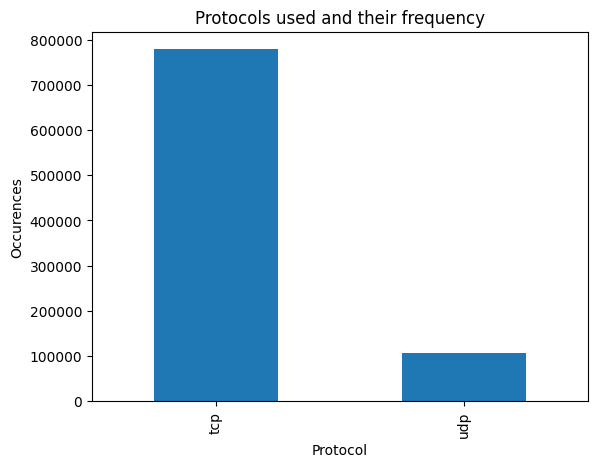

Ports used: [ 53 443]


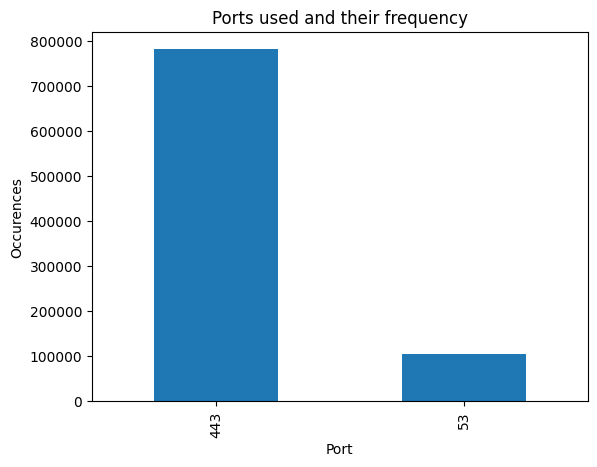

IPs used: ['192.168.101.228' '62.28.254.215' '148.69.168.40' ... '198.199.98.97'
 '97.107.142.40' '143.42.178.229']
No TCP connections on port 53
UDP connections on port 443:         timestamp           src_ip           dst_ip proto  port  up_bytes  \
index                                                                       
758018    1418193  192.168.101.108  142.250.184.156   udp   443     14077   
58683     1438675   192.168.101.49  142.250.184.131   udp   443     12913   
758080    1455931  192.168.101.108  142.250.184.161   udp   443     20008   
758150    1518579  192.168.101.108  142.250.184.175   udp   443     18668   
58849     1524002   192.168.101.49  142.250.184.130   udp   443     26906   
...           ...              ...              ...   ...   ...       ...   
174366    7914167   192.168.101.77  142.250.184.134   udp   443     12123   
527357    8010228  192.168.101.154  142.250.184.196   udp   443     24460   
839373    8049973  192.168.101.152  142.250.184.148   u

In [2]:
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 
from matplotlib import gridspec

def bytes_to_mb(bytes):
    return bytes / 1000000

def ts_to_hours(ts):
    ts = ts/100
    hours, rem = divmod(ts, 3600)
    minutes, secs = divmod(rem, 60)
    return "{:02}:{:02}:{:02}".format(int(hours), int(minutes), int(secs))

datafile='./../dataset1/data1.parquet'

### Read parquet data files
data = pd.read_parquet(datafile)

print("Uploads: " + str(data['up_bytes'].describe()))
print("\nDownloads: " + str(data['down_bytes'].describe()))

# Check what protocols were used
protocols = data['proto'].unique()
print("Protocols used: " + str(protocols))
data['proto'].value_counts().plot(kind='bar')
plt.title('Protocols used and their frequency')
plt.xlabel('Protocol')
plt.ylabel('Occurences')
plt.show()

# Check what ports were used
ports = data['port'].unique()
print("Ports used: " + str(ports))
data['port'].value_counts().plot(kind='bar')
plt.title('Ports used and their frequency')
plt.xlabel('Port')
plt.ylabel('Occurences')
plt.show()

# Check what IPs were used
ips = data['dst_ip'].unique()
print("IPs used: " + str(ips))

# UDP port 53 --> DNS
# UDP port 443 --> QUIC
# TCP port 443 --> HTTPS

# Verify that port 53 only has UDP connections
tcp53 = data.loc[(data['port'] == 53) & (data['proto'] != 'udp')]
if tcp53.empty:
    print("No TCP connections on port 53")
else:
    print("TCP connections on port 53: " + str(tcp53))

# Verify that port 443 only has TCP connections
udp443 = data.loc[(data['port'] == 443) & (data['proto'] != 'tcp')]
if udp443.empty:
    print("No UDP connections on port 443")
else:
    print("UDP connections on port 443: " + str(udp443))
 
# Add the country code to flow data
gi = pygeoip.GeoIP('./../GeoIP_DBs/GeoIP.dat')
data['dst_cc'] = data['dst_ip'].apply(lambda x: gi.country_code_by_addr(x))

# Check the connections to each country
countries = data['dst_cc'].unique()
print("Countries: " + str(countries))

# Add the organization to flow data
gi2 = pygeoip.GeoIP('./../GeoIP_DBs/GeoIPASNum.dat')
data['dst_org'] = data['dst_ip'].apply(lambda x: gi2.org_by_addr(x))

# Check the connections to each organization
organizations = data['dst_org'].unique()
print("Organizations: " + str(organizations))

# Timestamp to hours
data['ts_in_hours'] = data['timestamp'].apply(lambda x: ts_to_hours(x))

#Is destination IPv4 a public address?
NET=ipaddress.IPv4Network('192.168.101.0/24')
bpublic=data.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1)

# concat data with cc and org on the collum
data_extra_info = pd.concat([data, data['dst_cc'], data['dst_org'], data['ts_in_hours']], axis=1)


## Non anomalous data analysis

### Internal Communications Analysis

Number of UDP flows for each source IP:                  timestamp  dst_ip  proto  port  up_bytes  down_bytes  dst_cc  \
src_ip                                                                          
192.168.101.100        363     363    363   363       363         363     363   
192.168.101.101       1077    1077   1077  1077      1077        1077    1077   
192.168.101.102         81      81     81    81        81          81      81   
192.168.101.103        665     665    665   665       665         665     665   
192.168.101.104        248     248    248   248       248         248     248   
...                    ...     ...    ...   ...       ...         ...     ...   
192.168.101.95         265     265    265   265       265         265     265   
192.168.101.96         277     277    277   277       277         277     277   
192.168.101.97         531     531    531   531       531         531     531   
192.168.101.98         343     343    343   343       343         343

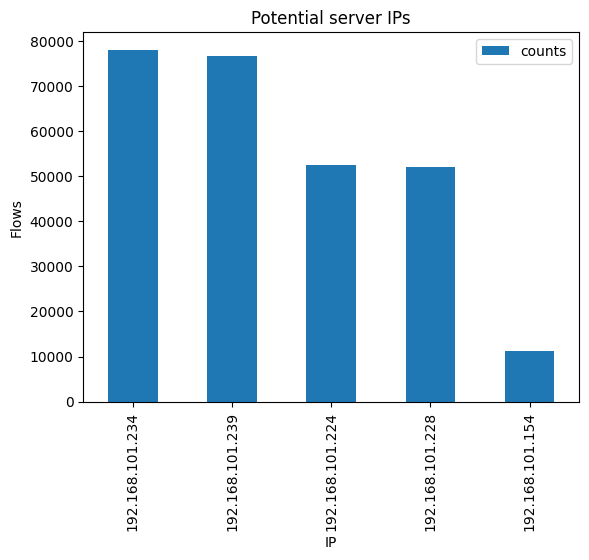

Number of UDP flow to port 53 (DNS), for each source IP, using UDP:                  timestamp  dst_ip  proto  port  up_bytes  down_bytes  dst_cc  \
src_ip                                                                          
192.168.101.100        363     363    363   363       363         363     363   
192.168.101.101       1077    1077   1077  1077      1077        1077    1077   
192.168.101.102         81      81     81    81        81          81      81   
192.168.101.103        665     665    665   665       665         665     665   
192.168.101.104        248     248    248   248       248         248     248   
...                    ...     ...    ...   ...       ...         ...     ...   
192.168.101.95         265     265    265   265       265         265     265   
192.168.101.96         277     277    277   277       277         277     277   
192.168.101.97         531     531    531   531       531         531     531   
192.168.101.98         343     343    343

In [42]:

# Flows from internal IPs to internal IPs (192.168.101.X)
internal_flows = data.loc[(data['src_ip'].str.startswith('192.168.101.')) & (data['dst_ip'].str.startswith('192.168.101.'))]

# Number of UDP flows for each source IP (internal flows)
nudpF_internal = internal_flows.loc[internal_flows['proto']=='udp'].groupby(['src_ip']).count()
print("Number of UDP flows for each source IP: " + str(nudpF_internal))

# Number of TCP flows for each source IP (internal flows)
ntcpF_internal = internal_flows.loc[internal_flows['proto']=='tcp'].groupby(['src_ip']).count()
print("Number of TCP flows for each source IP counting upload bytes: " + str(ntcpF_internal))

# Verify which IPs belong to servers (IPs that are private (start with 192.168.101.X) that have more communication, both as source or destination)
src_ips = data.loc[data['src_ip'].str.startswith('192.168.101.')].groupby('src_ip').size().reset_index(name='counts')
dst_ips = data.loc[data['dst_ip'].str.startswith('192.168.101.')].groupby('dst_ip').size().reset_index(name='counts')

# Check what's the average value of the counts
print("Average value of the counts: " + str(src_ips['counts'].mean()))

# Combine the counts
server_ips = src_ips.set_index('src_ip').add(dst_ips.set_index('dst_ip'), fill_value=0).reset_index().sort_values(by='counts', ascending=False).reset_index(drop=True)

print("Server IPs: " + str(server_ips))

# Average value of the counts without the top 4 IPs
print("Average value of the counts without the top 4 IPs: " + str(server_ips['counts'][4:].mean()))



# Plot the top 6 server IPs
server_ips.head(5).plot(kind='bar', x='index', y='counts')
plt.title('Potential server IPs')
plt.xlabel('IP')
plt.ylabel('Flows')
plt.savefig('./../plots/top5_potential_server_ips.png')
plt.show()


##
# Number of UDP flow to port 53 (DNS), for each source IP (internal flows)
nudpF53_internal = internal_flows.loc[(internal_flows['proto']=='udp')&(internal_flows['port']==53)].groupby(['src_ip']).count()
print("Number of UDP flow to port 53 (DNS), for each source IP, using UDP: " + str(nudpF53_internal))

# Total uploaded bytes to destination port 53 using UDP, for each source IP (internal flows)
upS_internal = internal_flows.loc[((internal_flows['proto']=='udp')&(internal_flows['port']==53))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 53 using UDP, for each source IP: " + str(upS_internal))


##
# Number of UDP flows to port 443, for each source IP (internal flows)
nudpF443_internal = internal_flows.loc[(internal_flows['proto']=='udp')&(internal_flows['port']==443)].groupby(['src_ip']).count()
print("Number of UDP flows to port 443 (QUIC), for each source IP, using UDP: " + str(nudpF443_internal))

# Total uploaded bytes to destination port 443 using UDP, for each source IP (internal flows)
upS_internal = internal_flows.loc[((internal_flows['proto']=='udp')&(internal_flows['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443 using UDP, for each source IP: " + str(upS_internal))


##
# Number of TCP flows to port 443, for each source IP (internal flows)
ntcpF443_internal = internal_flows.loc[(internal_flows['proto']=='tcp')&(internal_flows['port']==443)].groupby(['src_ip']).count()
print("Number of TCP flows to port 443 (HTTPS), for each source IP, using TCP: " + str(ntcpF443_internal))

# Total uploaded bytes to destination port 443 using TCP, for each source IP (internal flows)
upS_internal = internal_flows.loc[((internal_flows['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443, for each source IP: " + str(upS_internal))


##
# Uploaded bytes per flow, for each source IP (internal flows)
upF_internal = internal_flows.groupby(['src_ip'])['up_bytes'].sum()
print("Uploaded bytes per flow, for each source IP: " + str(upF_internal))

# Downloaded bytes per flow, for each source IP (internal flows)
downS_internal = internal_flows.groupby(['src_ip'])['down_bytes'].sum()
print("Downloaded bytes per flow, for each source IP: " + str(downS_internal))


##
# Normal timestamps per source IP flows
ts_internal = internal_flows.groupby(['src_ip'])['timestamp'].mean()
print("Normal timestamps per source IP flows: " + str(ts_internal))

# Check flows per country (internal flows)
cc_internal = internal_flows.groupby(['dst_cc']).count()
print("Flows per country: " + str(cc_internal))

# Check flows per organization (internal flows)
org_internal = internal_flows.groupby(['dst_org']).count()
print("Flows per organization: " + str(org_internal))

### Internal communications statistics

In [4]:
# Mean, Standard Deviation and Variance of the flows to private IPs
print("Mean of the flows to private IPs: " + str(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private).mean()))
print("Standard Deviation of the flows to private IPs: " + str(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private).std()))
print("Variance of the flows to private IPs: " + str(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private).var()))

# Mean, Standard Deviation and Variance of the uploaded bytes per flow to private IPs
print("Mean of the uploaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].mean()))
print("Standard Deviation of the uploaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].std()))
print("Variance of the uploaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].var()))

# Mean, Standard Deviation and Variance of the total uploaded bytes to private IPs
print("Mean of the total uploaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].sum()))
print("Standard Deviation of the total uploaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].sum()))
print("Variance of the total uploaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].sum()))

# Mean, Standard Deviation and Variance of the downloaded bytes per flow to private IPs
print("Mean of the downloaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].mean()))
print("Standard Deviation of the downloaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].std()))
print("Variance of the downloaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].var()))

# Mean, Standard Deviation and Variance of the total downloaded bytes to private IPs
print("Mean of the total downloaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].sum()))
print("Standard Deviation of the total downloaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].sum()))
print("Variance of the total downloaded bytes to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].sum()))

# Mean, Standard Deviation and Variance of UDP flows to private IPs
print("Mean of the UDP flows to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(internal_flows['proto']=='udp')].groupby(['src_ip']).count().mean()))
print("Standard Deviation of the UDP flows to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(internal_flows['proto']=='udp')].groupby(['src_ip']).count().std()))
print("Variance of the UDP flows to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(internal_flows['proto']=='udp')].groupby(['src_ip']).count().var()))

# Mean, Standard Deviation and Variance of TCP flows to private IPs
print("Mean of the TCP flows to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(internal_flows['proto']=='tcp')].groupby(['src_ip']).count().mean()))
print("Standard Deviation of the TCP flows to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(internal_flows['proto']=='tcp')].groupby(['src_ip']).count().std()))
print("Variance of the TCP flows to private IPs: " + str(internal_flows.loc[(internal_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(internal_flows['proto']=='tcp')].groupby(['src_ip']).count().var()))



Mean of the flows to private IPs: 1.0
Standard Deviation of the flows to private IPs: 0.0
Variance of the flows to private IPs: 0.0
Mean of the uploaded bytes to private IPs: 6850.546660904394
Standard Deviation of the uploaded bytes to private IPs: 7264.241069762093
Variance of the uploaded bytes to private IPs: 52769198.319618315
Mean of the total uploaded bytes to private IPs: 1775367121
Standard Deviation of the total uploaded bytes to private IPs: 1775367121
Variance of the total uploaded bytes to private IPs: 1775367121
Mean of the downloaded bytes to private IPs: 57760.77896796151
Standard Deviation of the downloaded bytes to private IPs: 64494.26073449226
Variance of the downloaded bytes to private IPs: 4159509667.68867
Mean of the total downloaded bytes to private IPs: 14969110195
Standard Deviation of the total downloaded bytes to private IPs: 14969110195
Variance of the total downloaded bytes to private IPs: 14969110195
Mean of the UDP flows to private IPs: timestamp      53

### External Communications Analysis

In [5]:
# Flows from external IPs to external IPs (192.168.101.X)
external_flows = data.loc[(data['src_ip'].str.startswith('192.168.101.')) & (~data['dst_ip'].str.startswith('192.168.101.'))]

# Number of UDP flows for each source IP (external flows)
nudpF_external = external_flows.loc[external_flows['proto']=='udp'].groupby(['src_ip']).count()
print("Number of UDP flows for each source IP: " + str(nudpF_external))

# Number of TCP flows for each source IP (external flows)
ntcpF_external = external_flows.loc[external_flows['proto']=='tcp'].groupby(['src_ip']).count()
print("Number of TCP flows for each source IP counting upload bytes: " + str(ntcpF_external))


##
# Number of UDP flow to port 53 (DNS), for each source IP (external flows)
nudpF53_external = external_flows.loc[(external_flows['proto']=='udp')&(external_flows['port']==53)].groupby(['src_ip']).count()
print("Number of UDP flow to port 53 (DNS), for each source IP, using UDP: " + str(nudpF53_external))

# Total uploaded bytes to destination port 53 using UDP, for each source IP (external flows)
upS_external = external_flows.loc[((external_flows['proto']=='udp')&(external_flows['port']==53))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 53 using UDP, for each source IP: " + str(upS_external))


##
# Number of UDP flows to port 443, for each source IP (external flows)
nudpF443_external = external_flows.loc[(external_flows['proto']=='udp')&(external_flows['port']==443)].groupby(['src_ip']).count()
print("Number of UDP flows to port 443 (QUIC), for each source IP, using UDP: " + str(nudpF443_external))

# Total uploaded bytes to destination port 443 using UDP, for each source IP (external flows)
upS_external = external_flows.loc[((external_flows['proto']=='udp')&(external_flows['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443 using UDP, for each source IP: " + str(upS_external))


##
# Number of TCP flows to port 443, for each source IP (external flows)
ntcpF443_external = external_flows.loc[(external_flows['proto']=='tcp')&(external_flows['port']==443)].groupby(['src_ip']).count()
print("Number of TCP flows to port 443 (HTTPS), for each source IP, using TCP: " + str(ntcpF443_external))

# Total uploaded bytes to destination port 443 using TCP, for each source IP (external flows)
upS_external = external_flows.loc[((external_flows['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443, for each source IP: " + str(upS_external))


##
# Uploaded bytes per flow, for each source IP (external flows)
upF_external = external_flows.groupby(['src_ip'])['up_bytes'].sum()
print("Uploaded bytes per flow, for each source IP: " + str(upF_external))

# Downloaded bytes per flow, for each source IP (external flows)
downS_external = external_flows.groupby(['src_ip'])['down_bytes'].sum()
print("Downloaded bytes per flow, for each source IP: " + str(downS_external))


##
# Normal timestamps per source IP flows
ts_external = external_flows.groupby(['src_ip'])['timestamp'].mean()
print("Normal timestamps per source IP flows: " + str(ts_external))

# Check flows per country (external flows)
cc_external = external_flows.groupby(['dst_cc']).count()
print("Flows per country: " + str(cc_external))

# Check flows per organization (external flows)
org_external = external_flows.groupby(['dst_org']).count()
print("Flows per organization: " + str(org_external))


Number of UDP flows for each source IP:                  timestamp  dst_ip  proto  port  up_bytes  down_bytes  dst_cc  \
src_ip                                                                          
192.168.101.100          9       9      9     9         9           9       9   
192.168.101.101         23      23     23    23        23          23      23   
192.168.101.102          2       2      2     2         2           2       2   
192.168.101.103          9       9      9     9         9           9       9   
192.168.101.104          3       3      3     3         3           3       3   
...                    ...     ...    ...   ...       ...         ...     ...   
192.168.101.95           6       6      6     6         6           6       6   
192.168.101.96           8       8      8     8         8           8       8   
192.168.101.97          17      17     17    17        17          17      17   
192.168.101.98          12      12     12    12        12          12

### External communications statistics

In [6]:
# Mean, Standard Deviation and Variance of the flows to public IPs
print("Mean of the flows to public IPs: " + str(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private).mean()))
print("Standard Deviation of the flows to public IPs: " + str(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private).std()))
print("Variance of the flows to public IPs: " + str(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private).var()))

# Mean, Standard Deviation and Variance of the uploaded bytes per flow to public IPs
print("Mean of the uploaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].mean()))
print("Standard Deviation of the uploaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].std()))
print("Variance of the uploaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].var()))

# Mean, Standard Deviation and Variance of the total uploaded bytes to public IPs
print("Mean of the total uploaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].sum()))
print("Standard Deviation of the total uploaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].sum()))
print("Variance of the total uploaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['up_bytes'].sum()))

# Mean, Standard Deviation and Variance of the downloaded bytes per flow to public IPs
print("Mean of the downloaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].mean()))
print("Standard Deviation of the downloaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].std()))
print("Variance of the downloaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].var()))

# Mean, Standard Deviation and Variance of the total downloaded bytes to public IPs
print("Mean of the total downloaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].sum()))
print("Standard Deviation of the total downloaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].sum()))
print("Variance of the total downloaded bytes to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]['down_bytes'].sum()))

# Mean, Standard Deviation and Variance of UDP flows to public IPs
print("Mean of the UDP flows to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(external_flows['proto']=='udp')].groupby(['src_ip']).count().mean()))
print("Standard Deviation of the UDP flows to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(external_flows['proto']=='udp')].groupby(['src_ip']).count().std()))
print("Variance of the UDP flows to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(external_flows['proto']=='udp')].groupby(['src_ip']).count().var()))

# Mean, Standard Deviation and Variance of TCP flows to public IPs
print("Mean of the TCP flows to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(external_flows['proto']=='tcp')].groupby(['src_ip']).count().mean()))
print("Standard Deviation of the TCP flows to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(external_flows['proto']=='tcp')].groupby(['src_ip']).count().std()))
print("Variance of the TCP flows to public IPs: " + str(external_flows.loc[(external_flows['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))&(external_flows['proto']=='tcp')].groupby(['src_ip']).count().var()))



Mean of the flows to public IPs: 0.0
Standard Deviation of the flows to public IPs: 0.0
Variance of the flows to public IPs: 0.0
Mean of the uploaded bytes to public IPs: nan
Standard Deviation of the uploaded bytes to public IPs: nan
Variance of the uploaded bytes to public IPs: nan
Mean of the total uploaded bytes to public IPs: 0
Standard Deviation of the total uploaded bytes to public IPs: 0
Variance of the total uploaded bytes to public IPs: 0
Mean of the downloaded bytes to public IPs: nan
Standard Deviation of the downloaded bytes to public IPs: nan
Variance of the downloaded bytes to public IPs: nan
Mean of the total downloaded bytes to public IPs: 0
Standard Deviation of the total downloaded bytes to public IPs: 0
Variance of the total downloaded bytes to public IPs: 0
Mean of the UDP flows to public IPs: timestamp     NaN
dst_ip        NaN
proto         NaN
port          NaN
up_bytes      NaN
down_bytes    NaN
dst_cc        NaN
dst_org       NaN
ts_in_hours   NaN
dtype: float

# Anomalous Network Traffic Monitoring

## Agreggating information to the dataset

Uploads: count    1.132362e+06
mean     2.051585e+04
std      1.682738e+06
min      7.100000e+01
25%      2.920000e+02
50%      7.987000e+03
75%      1.242700e+04
max      4.586658e+08
Name: up_bytes, dtype: float64

Downloads: count    1.132362e+06
mean     7.893879e+04
std      1.373417e+05
min      7.300000e+01
25%      8.190000e+02
50%      6.535900e+04
75%      1.056790e+05
max      8.543258e+06
Name: down_bytes, dtype: float64
Protocols used: 
['udp' 'tcp']


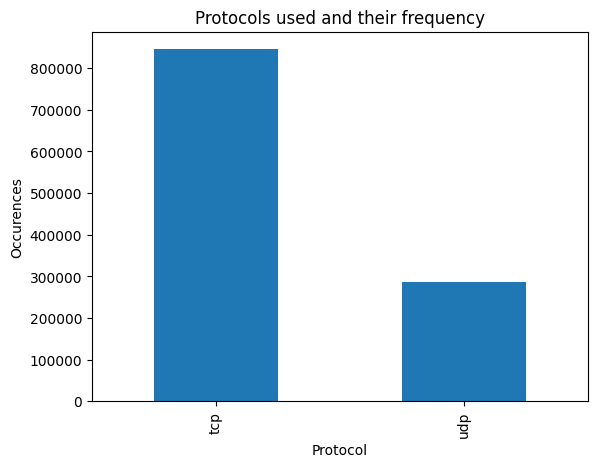

Ports used: 
[ 53 443]


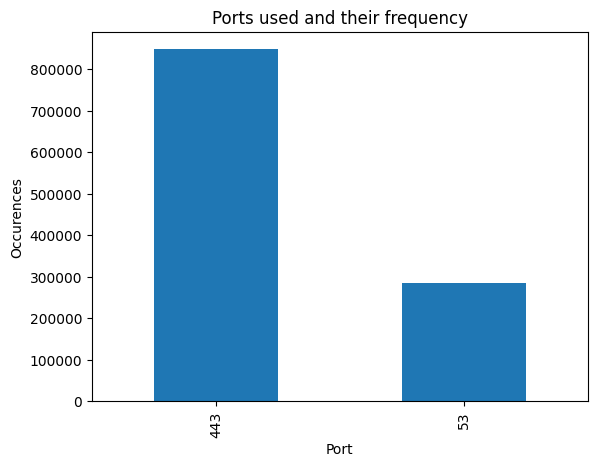

IPs used: ['192.168.101.228' '192.168.101.206' '192.168.101.234' ...
 '52.126.232.139' '52.126.235.39' '150.222.228.30']
No TCP connections on port 53

UDP connections on port 443: 
        timestamp           src_ip           dst_ip proto  port  up_bytes  \
index                                                                       
197800    1224873  192.168.101.160  142.250.184.194   udp   443     33264   
197932    1272901  192.168.101.160  142.250.184.138   udp   443     21156   
584727    1293539   192.168.101.67  142.250.184.244   udp   443     38184   
198091    1327306  192.168.101.160  142.250.184.180   udp   443     16168   
308501    1348820  192.168.101.156  142.250.184.167   udp   443     30438   
...           ...              ...              ...   ...   ...       ...   
253388    8119578  192.168.101.171  142.250.184.139   udp   443     23211   
352700    8149283  192.168.101.187  142.250.184.167   udp   443     28759   
253698    8257557  192.168.101.171  142.250.184.

In [7]:
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 

def bytes_to_mb(bytes):
    return bytes / 1000000

def ts_to_hours(ts):
    ts = ts/100
    hours, rem = divmod(ts, 3600)
    minutes, secs = divmod(rem, 60)
    return "{:02}:{:02}:{:02}".format(int(hours), int(minutes), int(secs))

testfile='./../dataset1/test1.parquet'

### Read parquet data files
test = pd.read_parquet(testfile)

print("Uploads: " + str(test['up_bytes'].describe()))
print("\nDownloads: " + str(test['down_bytes'].describe()))

# Check what protocols were used
protocols = test['proto'].unique()
print("Protocols used: \n" + str(protocols))
test['proto'].value_counts().plot(kind='bar')
plt.title('Protocols used and their frequency')
plt.xlabel('Protocol')
plt.ylabel('Occurences')
plt.show()

# Check what ports were used
ports = test['port'].unique()
print("Ports used: \n" + str(ports))
test['port'].value_counts().plot(kind='bar')
plt.title('Ports used and their frequency')
plt.xlabel('Port')
plt.ylabel('Occurences')
plt.show()

# Check what IPs were used
ips = test['dst_ip'].unique()
print("IPs used: " + str(ips))

# UDP port 53 --> DNS
# UDP port 443 --> QUIC
# TCP port 443 --> HTTPS

# Verify that port 53 only has UDP connections
tcp53 = test.loc[(test['port'] == 53) & (test['proto'] != 'udp')]
if tcp53.empty:
    print("No TCP connections on port 53\n")
else:
    print("TCP connections on port 53: \n" + str(tcp53))

# Verify that port 443 only has TCP connections
udp443 = test.loc[(test['port'] == 443) & (test['proto'] != 'tcp')]
if udp443.empty:
    print("No UDP connections on port 443\n")
else:
    print("UDP connections on port 443: \n" + str(udp443))
 
# Add the country code to flow test
gi = pygeoip.GeoIP('./../GeoIP_DBs/GeoIP.dat')
test['dst_cc'] = test['dst_ip'].apply(lambda x: gi.country_code_by_addr(x))

# Check the connections to each country
countries = test['dst_cc'].unique()
print("Countries: \n" + str(countries))

# Add the organization to flow test
gi2 = pygeoip.GeoIP('./../GeoIP_DBs/GeoIPASNum.dat')
test['dst_org'] = test['dst_ip'].apply(lambda x: gi2.org_by_addr(x))

# Check the connections to each organization
organizations = test['dst_org'].unique()
print("Organizations: \n" + str(organizations))

# Timestamp to hours
test['ts_in_hours'] = test['timestamp'].apply(lambda x: ts_to_hours(x))

#Is destination IPv4 a public address?
NET=ipaddress.IPv4Network('192.168.101.0/24')
bpublic=test.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1)

# concat test with cc and org on the collum
test_extra_info = pd.concat([data, data['dst_cc'], data['dst_org'], data['ts_in_hours']], axis=1)


## Anomalous data analysis

### Internal Communications Analysis

In [8]:
# Flows from internal IPs to internal IPs (192.168.101.X)
internal_flows_test = test.loc[(test['src_ip'].str.startswith('192.168.101.')) & (test['dst_ip'].str.startswith('192.168.101.'))]

# Number of UDP flows for each source IP (internal flows)
nudpF_internal_test = internal_flows_test.loc[internal_flows_test['proto']=='udp'].groupby(['src_ip']).count()
print("Number of UDP flows for each source IP: \n" + str(nudpF_internal_test))

# Number of TCP flows for each source IP (internal flows)
ntcpF_internal_test = internal_flows_test.loc[internal_flows_test['proto']=='tcp'].groupby(['src_ip']).count()
print("Number of TCP flows for each source IP counting upload bytes: \n" + str(ntcpF_internal_test))

# Verify which IPs belong to servers (IPs that are private (start with 192.168.101.X) that have more communication, both as source or destination)
src_ips_test = test.loc[test['src_ip'].str.startswith('192.168.101.')].groupby('src_ip').size().reset_index(name='counts')
dst_ips_test = test.loc[test['dst_ip'].str.startswith('192.168.101.')].groupby('dst_ip').size().reset_index(name='counts')

# Combine the counts
server_ips_test = src_ips_test.set_index('src_ip').add(dst_ips_test.set_index('dst_ip'), fill_value=0).reset_index().sort_values(by='counts', ascending=False).reset_index(drop=True)

print("Server IPs: " + str(server_ips_test))


##
# Number of UDP flow to port 53 (DNS), for each source IP (internal flows)
nudpF53_internal_test = internal_flows_test.loc[(internal_flows_test['proto']=='udp')&(internal_flows_test['port']==53)].groupby(['src_ip']).count()
print("Number of UDP flow to port 53 (DNS), for each source IP, using UDP: \n" + str(nudpF53_internal_test))

# Total uploaded bytes to destination port 53 using UDP, for each source IP (internal flows)
upS_internal_test = internal_flows_test.loc[((internal_flows_test['proto']=='udp')&(internal_flows_test['port']==53))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 53 using UDP, for each source IP: \n" + str(upS_internal_test))


##
# Number of UDP flows to port 443, for each source IP (internal flows)
nudpF443_internal_test = internal_flows_test.loc[(internal_flows_test['proto']=='udp')&(internal_flows_test['port']==443)].groupby(['src_ip']).count()
print("Number of UDP flows to port 443 (QUIC), for each source IP, using UDP: \n" + str(nudpF443_internal_test))

# Total uploaded bytes to destination port 443 using UDP, for each source IP (internal flows)
upS_internal_test = internal_flows_test.loc[((internal_flows_test['proto']=='udp')&(internal_flows_test['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443 using UDP, for each source IP: \n" + str(upS_internal_test))


##
# Number of TCP flows to port 443, for each source IP (internal flows)
ntcpF443_internal_test = internal_flows_test.loc[(internal_flows_test['proto']=='tcp')&(internal_flows_test['port']==443)].groupby(['src_ip']).count()
print("Number of TCP flows to port 443 (HTTPS), for each source IP, using TCP: \n" + str(ntcpF443_internal_test))

# Total uploaded bytes to destination port 443 using TCP, for each source IP (internal flows)
upS_internal_test = internal_flows_test.loc[((internal_flows_test['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443, for each source IP: \n" + str(upS_internal_test))


##
# Uploaded bytes per flow, for each source IP (internal flows)
upF_internal_test = internal_flows_test.groupby(['src_ip'])['up_bytes'].sum()
print("Uploaded bytes per flow, for each source IP: \n" + str(upF_internal_test))

# Downloaded bytes per flow, for each source IP (internal flows)
downS_internal_test = internal_flows_test.groupby(['src_ip'])['down_bytes'].sum()
print("Downloaded bytes per flow, for each source IP: \n" + str(downS_internal_test))


##
# Normal timestamps per source IP flows
ts_internal_test = internal_flows_test.groupby(['src_ip'])['timestamp'].mean()
print("Normal timestamps per source IP flows: \n" + str(ts_internal_test))

# Check flows per country (internal flows)
cc_internal_test = internal_flows_test.groupby(['dst_cc']).count()
print("Flows per country: \n" + str(cc_internal_test))

# Check flows per organization (internal flows)
org_internal_test = internal_flows_test.groupby(['dst_org']).count()
print("Flows per organization: \n" + str(org_internal_test))

Number of UDP flows for each source IP: 
                 timestamp  dst_ip  proto  port  up_bytes  down_bytes  dst_cc  \
src_ip                                                                          
192.168.101.100        232     232    232   232       232         232     232   
192.168.101.101        654     654    654   654       654         654     654   
192.168.101.102        676     676    676   676       676         676     676   
192.168.101.103       1248    1248   1248  1248      1248        1248    1248   
192.168.101.104        556     556    556   556       556         556     556   
...                    ...     ...    ...   ...       ...         ...     ...   
192.168.101.94          75      75     75    75        75          75      75   
192.168.101.95         204     204    204   204       204         204     204   
192.168.101.96         597     597    597   597       597         597     597   
192.168.101.98         775     775    775   775       775         77

### External Communications Analysis

In [9]:
# Flows from external IPs to external IPs (192.168.101.X)
external_flows_test = test.loc[(test['src_ip'].str.startswith('192.168.101.')) & (~test['dst_ip'].str.startswith('192.168.101.'))]

# Number of UDP flows for each source IP (external flows)
nudpF_external_test = external_flows_test.loc[external_flows_test['proto']=='udp'].groupby(['src_ip']).count()
print("Number of UDP flows for each source IP: \n" + str(nudpF_external_test))

# Number of TCP flows for each source IP (external flows)
ntcpF_external_test = external_flows_test.loc[external_flows_test['proto']=='tcp'].groupby(['src_ip']).count()
print("Number of TCP flows for each source IP counting upload bytes: \n" + str(ntcpF_external_test))


##
# Number of UDP flow to port 53 (DNS), for each source IP (external flows)
nudpF53_external_test = external_flows_test.loc[(external_flows_test['proto']=='udp')&(external_flows_test['port']==53)].groupby(['src_ip']).count()
print("Number of UDP flow to port 53 (DNS), for each source IP, using UDP: \n" + str(nudpF53_external_test))

# Total uploaded bytes to destination port 53 using UDP, for each source IP (external flows)
upS_external_test = external_flows_test.loc[((external_flows_test['proto']=='udp')&(external_flows_test['port']==53))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 53 using UDP, for each source IP: \n" + str(upS_external_test))


##
# Number of UDP flows to port 443, for each source IP (external flows)
nudpF443_external_test = external_flows_test.loc[(external_flows_test['proto']=='udp')&(external_flows_test['port']==443)].groupby(['src_ip']).count()
print("Number of UDP flows to port 443 (QUIC), for each source IP, using UDP: \n" + str(nudpF443_external_test))

# Total uploaded bytes to destination port 443 using UDP, for each source IP (external flows)
upS_external_test = external_flows_test.loc[((external_flows_test['proto']=='udp')&(external_flows_test['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443 using UDP, for each source IP: \n" + str(upS_external_test))


##
# Number of TCP flows to port 443, for each source IP (external flows)
ntcpF443_external_test = external_flows_test.loc[(external_flows_test['proto']=='tcp')&(external_flows_test['port']==443)].groupby(['src_ip']).count()
print("Number of TCP flows to port 443 (HTTPS), for each source IP, using TCP: \n" + str(ntcpF443_external_test))

# Total uploaded bytes to destination port 443 using TCP, for each source IP (external flows)
upS_external_test = external_flows_test.loc[((external_flows_test['port']==443))].groupby(['src_ip'])['up_bytes'].sum()
print("Total uploaded bytes to destination port 443, for each source IP: \n" + str(upS_external_test))


##
# Uploaded bytes per flow, for each source IP (external flows)
upF_external_test = external_flows_test.groupby(['src_ip'])['up_bytes'].sum()
print("Uploaded bytes per flow, for each source IP: \n" + str(upF_external_test))

# Downloaded bytes per flow, for each source IP (external flows)
downS_external_test = external_flows_test.groupby(['src_ip'])['down_bytes'].sum()
print("Downloaded bytes per flow, for each source IP: \n" + str(downS_external_test))


##
# Normal timestamps per source IP flows
ts_external_test = external_flows_test.groupby(['src_ip'])['timestamp'].mean()
print("Normal timestamps per source IP flows: \n" + str(ts_external_test))

# Check flows per country (external flows)
cc_external_test = external_flows_test.groupby(['dst_cc']).count()
print("Flows per country: \n" + str(cc_external_test))

# Check flows per organization (external flows)
org_external_test = external_flows_test.groupby(['dst_org']).count()
print("Flows per organization: \n" + str(org_external_test))


Number of UDP flows for each source IP: 
                 timestamp  dst_ip  proto  port  up_bytes  down_bytes  dst_cc  \
src_ip                                                                          
192.168.101.100          5       5      5     5         5           5       5   
192.168.101.101         20      20     20    20        20          20      20   
192.168.101.102         11      11     11    11        11          11      11   
192.168.101.103         20      20     20    20        20          20      20   
192.168.101.104          9       9      9     9         9           9       9   
...                    ...     ...    ...   ...       ...         ...     ...   
192.168.101.94           1       1      1     1         1           1       1   
192.168.101.95           6       6      6     6         6           6       6   
192.168.101.96          11      11     11    11        11          11      11   
192.168.101.98          17      17     17    17        17          1

# Comparing Non Anomolous and Anomolous Network Traffic

## Regular verifications

In [10]:
# Check the used protocols
if (data['proto'].unique() == test['proto'].unique()).all():
    print("Protocols used are the same\n")
else:
    print("The different protocols used are: \n" + str(np.setdiff1d(data['proto'].unique(), test['proto'].unique())))

# Check the used ports
if (data['port'].unique() == test['port'].unique()).all():
    print("Ports used are the same\n")
else:
    print("The different ports used are: \n" + str(np.setdiff1d(data['port'].unique(), test['port'].unique())))


Protocols used are the same

Ports used are the same



## Anomolous verifications

### Server attacks

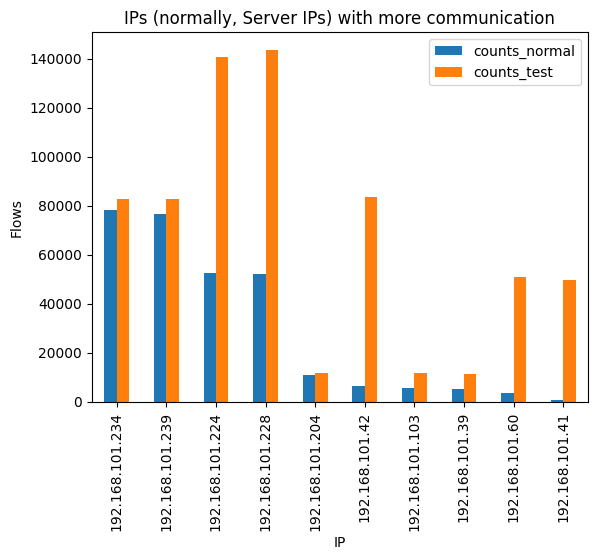

IPs that communicate with the Server IPs and how many flows: 
              src_ip  counts
0    192.168.101.100     900
1    192.168.101.101    2699
2    192.168.101.102     179
3    192.168.101.103    1690
4    192.168.101.104     669
..               ...     ...
191   192.168.101.95     615
192   192.168.101.96     626
193   192.168.101.97    1258
194   192.168.101.98     827
195   192.168.101.99    1190

[196 rows x 2 columns]
IPs that communicate with the "Server IPs" (and others with too traffic) and how many flows (test): 
              src_ip  counts_test
0    192.168.101.100          656
1    192.168.101.101         1673
2    192.168.101.102         1474
3    192.168.101.103         3024
4    192.168.101.104         1296
..               ...          ...
191   192.168.101.94          205
192   192.168.101.95          586
193   192.168.101.96         1381
194   192.168.101.98         1812
195   192.168.101.99         1456

[196 rows x 2 columns]
Increase of communication in perc

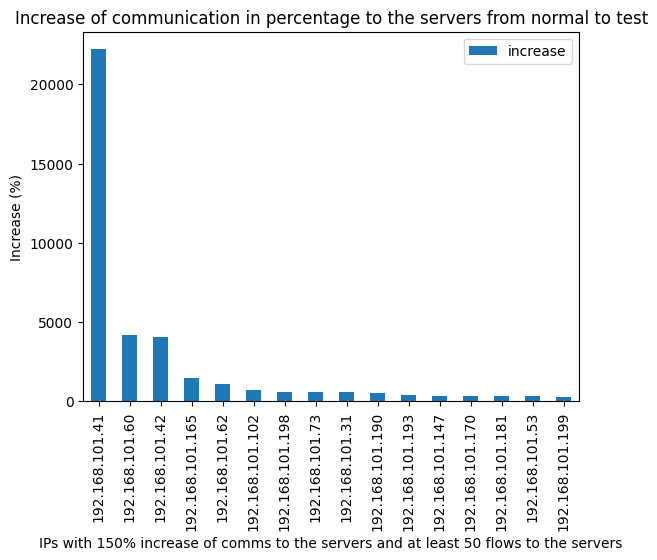

/tmp/ipykernel_9005/1233500090.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timeline_server_attackers['timestamp'] = timeline_server_attackers['timestamp'].apply(lambda x: ts_to_hours(x))


In [11]:
# How the server_ips are obtained
# # Verify which IPs belong to servers (IPs that are private (start with 192.168.101.X) that have more communication, both as source or destination)
# src_ips = data[data['src_ip'].str.startswith('192.168.101.')].groupby('src_ip').size().reset_index(name='counts')
# dst_ips = data[data['dst_ip'].str.startswith('192.168.101.')].groupby('dst_ip').size().reset_index(name='counts')

# server_ips = src_ips.set_index('src_ip').add(dst_ips.set_index('dst_ip'), fill_value=0).reset_index().sort_values(by='counts', ascending=False).reset_index(drop=True)


# How the server_ips_test are obtained
# # Verify which IPs belong to servers (IPs that are private (start with 192.168.101.X) that have more communication, both as source or destination)
# src_ips_test = test[test['src_ip'].str.startswith('192.168.101.')].groupby('src_ip').size().reset_index(name='counts')
# dst_ips_test = test[test['dst_ip'].str.startswith('192.168.101.')].groupby('dst_ip').size().reset_index(name='counts')

# server_ips_test = src_ips_test.set_index('src_ip').add(dst_ips_test.set_index('dst_ip'), fill_value=0).reset_index().sort_values(by='counts', ascending=False).reset_index(drop=True)


# Server IPs differences (top 10 of the most used IPs on test)
top_10_server_ips_test = server_ips_test.head(10)['index'].tolist()
# Filter the normal data for the rows that have the top 10 server IPs of the test
filter_data = server_ips[server_ips['index'].isin(top_10_server_ips_test)]
# Merge to check differences
merge = pd.merge(filter_data, server_ips_test, how='inner', left_on='index', right_on='index', suffixes=('_normal', '_test'))

# Make a plot for this differences (top 10 so that there are some references of normal behaviour)
merge.plot(x='index', y=['counts_normal', 'counts_test'], kind='bar', title="IPs (normally, Server IPs) with more communication", xlabel="IP", ylabel="Flows")
plt.savefig('./../plots/ips_with_more_communication.png')
plt.show()

# Check which IPs normally communicate with the Server IPs and how many flows
server_ips_flows = data.loc[data['dst_ip'].isin(server_ips['index'])].groupby(['src_ip']).size().reset_index(name='counts')
#server_ips_flows = server_ips_flows.sort_values(by='src_ip', ascending=False)
print("IPs that communicate with the Server IPs and how many flows: \n" + str(server_ips_flows))

# Check which IPs communicate with the Server IPs and how many flows (test) and order them by IP
server_ips_flows_test = test.loc[test['dst_ip'].isin(server_ips_test['index'])].groupby(['src_ip']).size().reset_index(name='counts_test')
#server_ips_flows_test = server_ips_flows_test.sort_values(by='src_ip', ascending=False)
print("IPs that communicate with the \"Server IPs\" (and others with too traffic) and how many flows (test): \n" + str(server_ips_flows_test))

# Merge to check differences
possible_server_attackers = pd.merge(server_ips_flows, server_ips_flows_test, how='outer', on='src_ip')

# Fill NaN with 0, since NaN represents no flows aka 0
possible_server_attackers = possible_server_attackers.fillna(0)

# Check the increase of communication in percentage to the servers from normal to test
possible_server_attackers['increase'] = ((possible_server_attackers['counts_test'] - possible_server_attackers['counts']) / possible_server_attackers['counts']) * 100
possible_server_attackers.sort_values(by='increase', ascending=False, inplace=True)
print("Increase of communication in percentage to the servers from normal to test: \n" + str(possible_server_attackers))

## This values need to be justified (and maybe changed)
# Collecting the flows with an increase over 150% or inf, have more than 50 flows to the servers
server_attackers_ips = possible_server_attackers.loc[((possible_server_attackers['increase'] > 250) | (possible_server_attackers['increase'] == np.inf)) & (possible_server_attackers['counts'] > 50)]
print("Possible server attackers IPs that have an increase over 250% or inf, have more than 50 flows to the servers: \n" + str(server_attackers_ips))

# Graph with the increase of communication in percentage to the servers from normal to test
server_attackers_ips.plot(x='src_ip', y='increase', kind='bar', title="Increase of communication in percentage to the servers from normal to test", xlabel="IPs with 150% increase of comms to the servers and at least 50 flows to the servers", ylabel="Increase (%)")
plt.savefig('./../plots/increase_communication_to_servers.png')
plt.show()

# Keeping only the IPs with increase over 500% 
server_attackers_ips = server_attackers_ips.loc[server_attackers_ips['increase'] > 500]

# Check the comms over time of the possible IPs that are attacking the servers
timeline_server_attackers = test.loc[(test['src_ip'].isin(server_attackers_ips['src_ip']))]
timeline_server_attackers['timestamp'] = timeline_server_attackers['timestamp'].apply(lambda x: ts_to_hours(x))

# Isolate things here and analyze them

### Botnet detection

New IPs that are communicating internally: 
['192.168.101.11' '192.168.101.110' '192.168.101.14' '192.168.101.34']
Botnet Suspect IPs that are communicating internally, with which IPs and how many flows: 
             src_ip           dst_ip  counts
0    192.168.101.11  192.168.101.206      28
1    192.168.101.11  192.168.101.224     190
2    192.168.101.11  192.168.101.228     171
3    192.168.101.11  192.168.101.234     312
4    192.168.101.11  192.168.101.239     301
5    192.168.101.11   192.168.101.38      31
6    192.168.101.11   192.168.101.67      24
7    192.168.101.11   192.168.101.85      29
8   192.168.101.110  192.168.101.224     136
9   192.168.101.110  192.168.101.228     117
10  192.168.101.110  192.168.101.234     207
11  192.168.101.110  192.168.101.239     113
12   192.168.101.14  192.168.101.224     142
13   192.168.101.14  192.168.101.228     113
14   192.168.101.14  192.168.101.234     200
15   192.168.101.14  192.168.101.239     166
16   192.168.101.34  192.168.1

/tmp/ipykernel_9005/372085828.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_11['timestamp'] = bot_11['timestamp'].apply(lambda x: ts_to_hours(x))
/tmp/ipykernel_9005/372085828.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bot_110['timestamp'] = bot_110['timestamp'].apply(lambda x: ts_to_hours(x))
/tmp/ipykernel_9005/372085828.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Botnet 11 Suspect IPs that are communicating externally, with which IPs, how many flows, and the protocol and port: 
           src_ip           dst_ip proto  port  counts
0  192.168.101.11  192.168.101.206   tcp   443      28
1  192.168.101.11  192.168.101.224   udp    53     190
2  192.168.101.11  192.168.101.228   udp    53     171
3  192.168.101.11  192.168.101.234   tcp   443     312
4  192.168.101.11  192.168.101.239   tcp   443     301
5  192.168.101.11   192.168.101.38   tcp   443      31
6  192.168.101.11   192.168.101.67   tcp   443      24
7  192.168.101.11   192.168.101.85   tcp   443      29
Botnet 110 Suspect IPs that are communicating externally, with which IPs, how many flows, and the protocol and port: 
            src_ip           dst_ip proto  port  counts
0  192.168.101.110  192.168.101.224   udp    53     136
1  192.168.101.110  192.168.101.228   udp    53     117
2  192.168.101.110  192.168.101.234   tcp   443     207
3  192.168.101.110  192.168.101.239   tcp   44

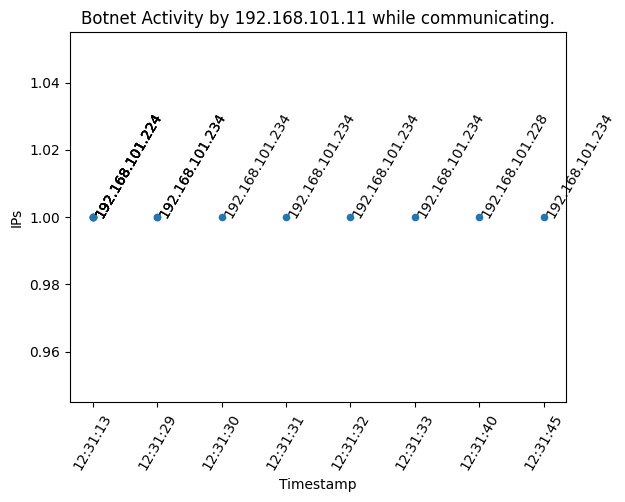

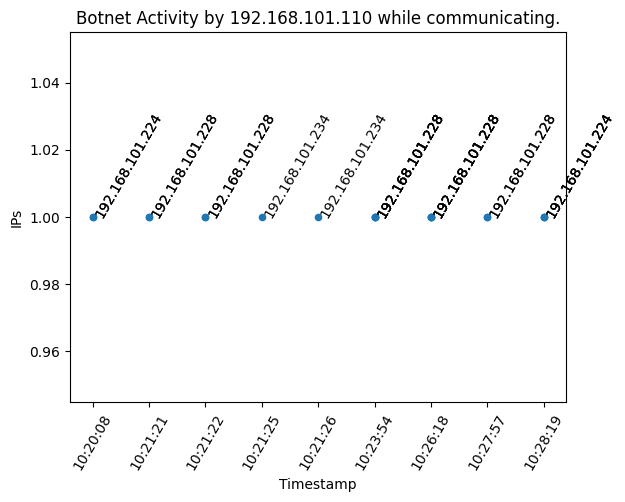

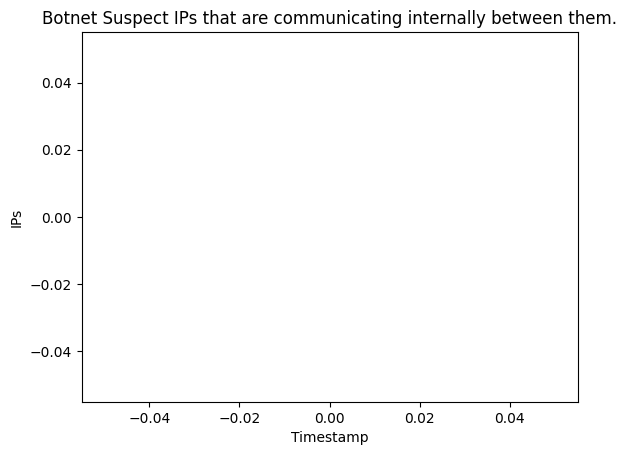

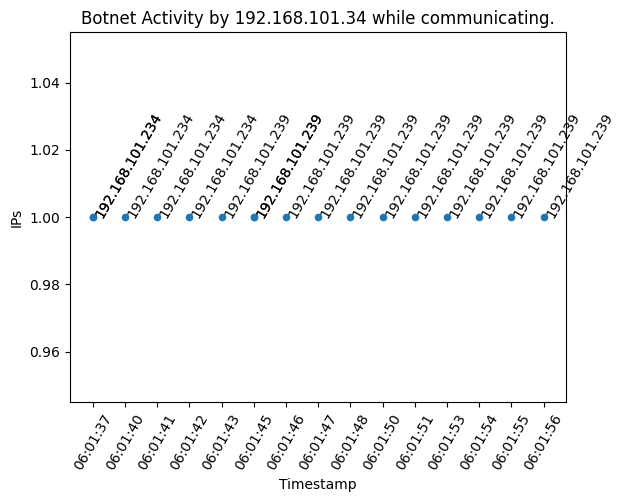

In [74]:
# Having internal_flows and internal_flows_test from the previous cells, we can check new IPs that are communicating internally
# Check the new IPs that are communicating internally
botnet_suspects_ips = np.setdiff1d(internal_flows_test['src_ip'].unique(), internal_flows['src_ip'].unique())
print("New IPs that are communicating internally: \n" + str(botnet_suspects_ips))

# Check if the botnet_suspect_ips are communicating with the other botnet_suspect_ips
botnet_suspects_ips_flows = internal_flows_test[internal_flows_test['src_ip'].isin(botnet_suspects_ips)]
botnet_suspects_ips_flows = botnet_suspects_ips_flows.groupby(['src_ip', 'dst_ip']).size().reset_index(name='counts')
print("Botnet Suspect IPs that are communicating internally, with which IPs and how many flows: \n" + str(botnet_suspects_ips_flows))

# Check the Protocol and Port of the between the botnet_suspect_ips and the IPs they communicate with
botnet_suspects_ips_flows_proto_port = internal_flows_test[internal_flows_test['src_ip'].isin(botnet_suspects_ips)]
botnet_suspects_ips_flows_proto_port = botnet_suspects_ips_flows_proto_port.groupby(['src_ip', 'dst_ip', 'proto', 'port']).size().reset_index(name='counts')
print("Botnet Suspect IPs that are communicating internally, with which IPs, how many flows, and the protocol and port: \n" + str(botnet_suspects_ips_flows_proto_port))

# Get the timeline from test from the 192.168.101.11 to the other botnet_suspects_ips
bot_11 = test.loc[(test['src_ip'] == '192.168.101.11') & (test['dst_ip'].isin(botnet_suspects_ips_flows['dst_ip']))]
# Add timestamp column
bot_11['timestamp'] = bot_11['timestamp'].apply(lambda x: ts_to_hours(x))

# Get the timeline from test from the 192.168.101.110 to the other botnet_suspects_ips
bot_110 = test.loc[(test['src_ip'] == '192.168.101.110') & (test['dst_ip'].isin(botnet_suspects_ips_flows['dst_ip']))]
# Add timestamp column
bot_110['timestamp'] = bot_110['timestamp'].apply(lambda x: ts_to_hours(x))

# Get the timeline from test from the 192.168.101.14 to the other botnet_suspects_ips
bot_14 = test.loc[(test['src_ip'] == '192.168.101.14') & (test['dst_ip'].isin(botnet_suspects_ips_flows['dst_ip']))]
# Add timestamp column
bot_14['timestamp'] = bot_14['timestamp'].apply(lambda x: ts_to_hours(x))

# Get the timeline from test from the 192.168.101.34 to the other botnet_suspects_ips
bot_34 = test.loc[(test['src_ip'] == '192.168.101.34') & (test['dst_ip'].isin(botnet_suspects_ips_flows['dst_ip']))]
# Add timestamp column
bot_34['timestamp'] = bot_34['timestamp'].apply(lambda x: ts_to_hours(x))

# Get the first 15 lines of the timeline from test
bot_11[['src_ip', 'dst_ip', 'timestamp']].head(15).reset_index(drop=True)
bot_110[['src_ip', 'dst_ip', 'timestamp']].head(15).reset_index(drop=True)
bot_14[['src_ip', 'dst_ip', 'timestamp']].head(15).reset_index(drop=True)
bot_34[['src_ip', 'dst_ip', 'timestamp']].head(15).reset_index(drop=True)

# Check what protocols and ports are used
print("Botnet 11 Suspect IPs that are communicating externally, with which IPs, how many flows, and the protocol and port: \n" + str(bot_11.groupby(['src_ip', 'dst_ip', 'proto', 'port']).size().reset_index(name='counts')))
print("Botnet 110 Suspect IPs that are communicating externally, with which IPs, how many flows, and the protocol and port: \n" + str(bot_110.groupby(['src_ip', 'dst_ip', 'proto', 'port']).size().reset_index(name='counts')))
print("Botnet 14 Suspect IPs that are communicating externally, with which IPs, how many flows, and the protocol and port: \n" + str(bot_14.groupby(['src_ip', 'dst_ip', 'proto', 'port']).size().reset_index(name='counts')))
print("Botnet 34 Suspect IPs that are communicating externally, with which IPs, how many flows, and the protocol and port: \n" + str(bot_34.groupby(['src_ip', 'dst_ip', 'proto', 'port']).size().reset_index(name='counts')))


# Keep the timestamp between 04:00:00 and 04:30:00
bot_11 = bot_11.loc[(bot_11['timestamp'] >= '12:30:00') & (bot_11['timestamp'] <= '12:32:00')]
bot_110 = bot_110.loc[(bot_110['timestamp'] >= '10:20:00') & (bot_110['timestamp'] <= '10:32:00')]
bot_14 = bot_14.loc[(bot_14['timestamp'] >= '00:00:00') & (bot_14['timestamp'] <= '07:30:00')]
bot_34 = bot_34.loc[(bot_34['timestamp'] >= '06:00:00') & (bot_34['timestamp'] <= '06:02:00')]

# Ignore this :D
bot_11['count'] = 1
bot_110['count'] = 1
bot_14['count'] = 1
bot_34['count'] = 1

#Make a scatter plot
bot_11.plot(x='timestamp', y='count', kind='scatter', title="Botnet Activity by 192.168.101.11 while communicating.", xlabel="Timestamp", ylabel="IPs")
plt.xticks(rotation=60)
# put the dst_ip over the points
for i, txt in enumerate(bot_11['dst_ip']):
    plt.annotate(txt, (bot_11['timestamp'].iloc[i], bot_11['count'].iloc[i]), rotation=60, fontsize=10)
plt.savefig('./../plots/bot_34_botnet_suspects_ips_communicating_internally.png')
plt.show()

bot_110.plot(x='timestamp', y='count', kind='scatter', title="Botnet Activity by 192.168.101.110 while communicating.", xlabel="Timestamp", ylabel="IPs")
plt.xticks(rotation=60)
# put the dst_ip over the points
for i, txt in enumerate(bot_110['dst_ip']):
    plt.annotate(txt, (bot_110['timestamp'].iloc[i], bot_110['count'].iloc[i]), rotation=60, fontsize=10)
plt.savefig('./../plots/bot_34_botnet_suspects_ips_communicating_internally.png')
plt.show()

bot_14.plot.scatter(x='timestamp', y='count', title="Botnet Suspect IPs that are communicating internally between them.", xlabel="Timestamp", ylabel="IPs")
plt.savefig('./../plots/bot_14_botnet_suspects_ips_communicating_internally.png')
plt.show()

bot_34.plot(x='timestamp', y='count', kind='scatter', title="Botnet Activity by 192.168.101.34 while communicating.", xlabel="Timestamp", ylabel="IPs")
plt.xticks(rotation=60)
# put the dst_ip over the points
for i, txt in enumerate(bot_34['dst_ip']):
    plt.annotate(txt, (bot_34['timestamp'].iloc[i], bot_34['count'].iloc[i]), rotation=60, fontsize=10)
plt.savefig('./../plots/bot_34_botnet_suspects_ips_communicating_internally.png')
plt.show()



### Anomolous External Activity - Data Exfiltration

New IPs that are communicating externally: 
['192.168.101.11' '192.168.101.110' '192.168.101.14' '192.168.101.34']
New IPs that are communicating from the exterior: 
['1.12.170.41' '101.194.64.156' '101.203.185.141' ... '99.83.117.88'
 '99.83.118.228' '99.83.118.23']
Internet Suspect IPs that are communicating externally and DOWNLOADING how much MBytes: 
src_ip
192.168.101.11     243.544328
192.168.101.110    175.307206
192.168.101.14     178.175953
192.168.101.34     408.718135
Name: down_bytes, dtype: float64
Internet Suspect IPs that are communicating externally and UPLOADING how much MBytes:
src_ip
192.168.101.11     26.886369
192.168.101.110    17.637547
192.168.101.14     19.224540
192.168.101.34     43.129404
Name: up_bytes, dtype: float64
Internet Suspect IPs that are communicating externally, with the public IPs: 
             src_ip           dst_ip proto  port  counts
436  192.168.101.34    172.217.17.14   tcp   443     272
38   192.168.101.11   142.250.200.68   tcp   443   

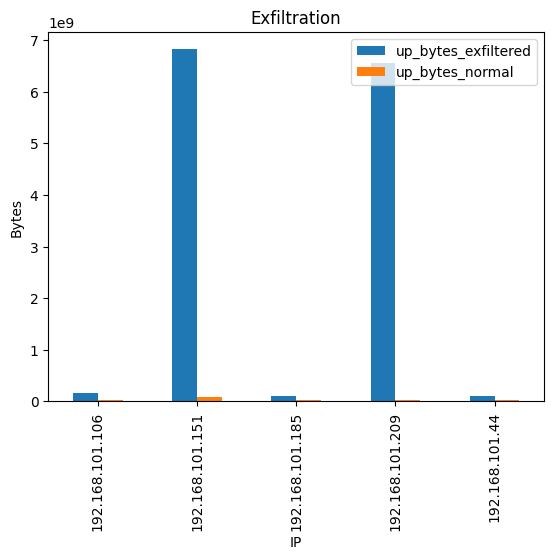

Exfiltration of more than 500MB: 
              src_ip           dst_ip  counts    up_bytes dst_cc  \
51   192.168.101.151  142.250.184.139      41  6753960147     US   
250  192.168.101.209     13.107.42.56      32  6529512410     US   

                                dst_org  
51                       AS15169 GOOGLE  
250  AS8068 MICROSOFT-CORP-MSN-AS-BLOCK  


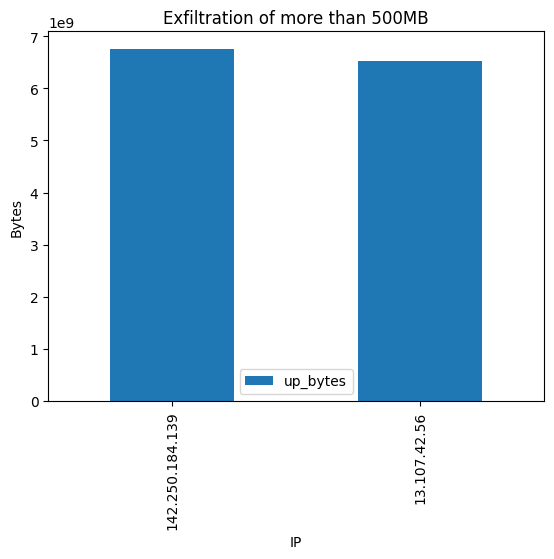

In [79]:
# Having already external_flows_test, we can check new IPs that are communicating externally and how much down_bytes and up_bytes they have
# Check the new IPs that are communicating externally
internet_suspect_ips = np.setdiff1d(external_flows_test['src_ip'].unique(), external_flows['src_ip'].unique())
print("New IPs that are communicating externally: \n" + str(internet_suspect_ips))

exterior_suspect_ips = np.setdiff1d(external_flows_test['dst_ip'].unique(), external_flows['dst_ip'].unique())
print("New IPs that are communicating from the exterior: \n" + str(exterior_suspect_ips))

# Check the down_bytes and up_bytes of the internet_suspects_ips using from_bytes_to_mb()
internet_suspects_ips_bytes = external_flows_test[external_flows_test['src_ip'].isin(internet_suspect_ips)]
internet_suspects_ips_down_bytes = internet_suspects_ips_bytes.groupby(['src_ip'])['down_bytes'].sum().apply(lambda x: bytes_to_mb(x))
internet_suspects_ips_up_bytes = internet_suspects_ips_bytes.groupby(['src_ip'])['up_bytes'].sum().apply(lambda x: bytes_to_mb(x))
print("Internet Suspect IPs that are communicating externally and DOWNLOADING how much MBytes: \n" + str(internet_suspects_ips_down_bytes) + "\n" + 
      "Internet Suspect IPs that are communicating externally and UPLOADING how much MBytes:\n" + str(internet_suspects_ips_up_bytes))

# Check which public IPs are they accessing
suspect_public_ips = internet_suspects_ips_bytes.groupby(['src_ip', 'dst_ip', 'proto', 'port']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print("Internet Suspect IPs that are communicating externally, with the public IPs: \n" + str(suspect_public_ips))

# Check which Country and Organization they are accessing
suspect_public_ips_cc_org = internet_suspects_ips_bytes.groupby(['src_ip', 'dst_ip', 'dst_cc', 'dst_org']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
print("Internet Suspect IPs that are communicating externally, with the public IPs, and the Country and Organization: \n" + str(suspect_public_ips_cc_org))

# Check the number of flows for each source IP (external flows)
info_outside_normal = external_flows.groupby(['src_ip', 'dst_ip']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

# Check the number of flows for each source IP (external flows of test)
info_outside_test = external_flows_test.groupby(['src_ip', 'dst_ip']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)

# Merge to check differences
info_outside = pd.merge(info_outside_normal, info_outside_test, on=['src_ip', 'dst_ip'], how='right')

# Percentage of increase of communication to the exterior
info_outside['increase'] = ((info_outside['counts_y'] - info_outside['counts_x']) / info_outside['counts_x']) * 100

# Keep the ones with increase > 150% or inf, and have more than 50 flows
info_outside = info_outside[((info_outside['increase'] > 150) | (info_outside['increase'] == np.inf)) & (info_outside['counts_y'] > 50)] 

# Maybe should conclude something else or smtg at all here
# Doesn't reach great values, therefore not alarming, I guess

## Data Exfiltration

# Check the number of bytes uploaded 
normal_up = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
# Check the number of flows to the internet
normal_flows = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip']).size().reset_index(name='counts')

# Check the number of bytes uploaded - test
test_up = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
# Check the number of flows to the internet - test
test_flows = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip']).size().reset_index(name='counts')

# Average uploaded bytes per flow
normal_up = pd.merge(normal_up, normal_flows, on='src_ip', how='inner')
normal_up['avg_up_bytes'] = normal_up['up_bytes'] / normal_up['counts']
# Average uploaded bytes per flow - test
test_up = pd.merge(test_up, test_flows, on='src_ip', how='inner')
test_up['avg_up_bytes'] = test_up['up_bytes'] / test_up['counts']

# Merge to check differences -- Only increases of 50% or more
up_bytes = pd.merge(normal_up, test_up, on='src_ip', how='inner')
up_bytes = up_bytes[(up_bytes['avg_up_bytes_y'] > (up_bytes['avg_up_bytes_x']*1.5))]

# Extract the destination IP where the up_bytes IP is communicating with
exfilt = data.loc[(data['src_ip'].isin(up_bytes['src_ip'])) & (~data['dst_ip'].str.startswith('192.168.101.'))]
exfilt = exfilt[['src_ip', 'dst_ip']]
# Add country and org
exfilt['dst_cc'] = exfilt['dst_ip'].apply(lambda x: gi.country_code_by_addr(x))
exfilt['dst_org'] = exfilt['dst_ip'].apply(lambda x: gi2.org_by_addr(x))

# From the exfilt, check the uploaded bytes to the internet (dst_ip not starting with 192.168.101.) from the src_ips there
exfilt_up = test.loc[(test['src_ip'].isin(exfilt['src_ip'])) & (~test['dst_ip'].str.startswith('192.168.101.'))].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes_exfiltered')
# The same for test dataset
exfilt_up['up_bytes_normal'] = data.loc[(data['src_ip'].isin(exfilt['src_ip'])) & (~data['dst_ip'].str.startswith('192.168.101.'))].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes_normal')['up_bytes_normal']

# Add the increase in percentage
exfilt_up['increase'] = ((exfilt_up['up_bytes_exfiltered'] - exfilt_up['up_bytes_normal']) / exfilt_up['up_bytes_normal']) * 100

# Plot the exfilt_up
exfilt_up.plot(x='src_ip', y=['up_bytes_exfiltered', 'up_bytes_normal'], kind='bar', title="Exfiltration", xlabel="IP", ylabel="Bytes")
plt.savefig('./../plots/exfiltration.png')
plt.show()


# Remove the ones who transmitted less than 500MB
exfilt_up_500MB = exfilt_up[exfilt_up['up_bytes_exfiltered'] > int(500e6) ]

# Check who this source IP has communications with
exfilt_500MB = test.loc[(test['src_ip'].isin(exfilt_up_500MB['src_ip'])) & (~test['dst_ip'].str.startswith('192.168.101.'))]

# Join the pairs src_ip - dst_ip with number of flows
exfilt_500MB = exfilt_500MB.groupby(['src_ip', 'dst_ip']).size().reset_index(name='counts')

# Get the uploaded bytes from the pairs (src_ip - dst_ip)
_upload_bytes = test.loc[(test['src_ip'].isin(exfilt_500MB['src_ip'])) & (test['dst_ip'].isin(exfilt_500MB['dst_ip']))].groupby(['src_ip', 'dst_ip'])['up_bytes'].sum().reset_index(name='up_bytes')

# Merge the info about exfiltration
exfilt_500MB = pd.merge(exfilt_500MB, _upload_bytes, on=['src_ip', 'dst_ip'], how='inner')

# keep the ones with more than 500MB
exfilt_500MB = exfilt_500MB[exfilt_500MB['up_bytes'] > int(500e6)]

# Add the country and org
exfilt_500MB['dst_cc'] = exfilt_500MB['dst_ip'].apply(lambda x: gi.country_code_by_addr(x))
exfilt_500MB['dst_org'] = exfilt_500MB['dst_ip'].apply(lambda x: gi2.org_by_addr(x))
print("Exfiltration of more than 500MB: \n" + str(exfilt_500MB))

# Plot this exfilt_500MB
exfilt_500MB.plot(x='dst_ip', y='up_bytes', kind='bar', title="Exfiltration of more than 500MB", xlabel="IP", ylabel="Bytes")
plt.savefig('./../plots/exfiltration_500MB.png')
plt.show()



# Check for periodic communication sending always the same amount of bytes
# Check the number of bytes uploaded per flow for each source IP
normal_upload = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
normal_flows_upload = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip']).size().reset_index(name='counts')
normal_upload = pd.merge(normal_upload, normal_flows, on='src_ip', how='inner')
normal_upload['avg_up_bytes'] = normal_upload['up_bytes'] / normal_upload['counts']

# Check the number of bytes uploaded per flow for each source IP - test
test_upload = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
test_flows_upload = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip']).size().reset_index(name='counts')
test_upload = pd.merge(test_upload, test_flows, on='src_ip', how='inner')
test_upload['avg_up_bytes'] = test_upload['up_bytes'] / test_upload['counts']







### Country statistics analysis

Countries with increase of communication to the exterior: 
   dst_cc  counts_x    up_bytes_x  down_bytes_x  up_bytes_mean_x  \
13     CN     151.0  1.745724e+06  1.537661e+07     11561.086093   
31     KR     129.0  1.539955e+06  1.279441e+07     11937.635659   
46     RU       0.0  0.000000e+00  0.000000e+00         0.000000   
57     US  315788.0  3.629995e+09  3.748396e+10     11495.036917   

    down_bytes_mean_x  counts_y   up_bytes_y  down_bytes_y  up_bytes_mean_y  \
13      101831.854305       859      9930936      84746574     11561.043073   
31       99181.457364       206      2334695      20255753     11333.470874   
46           0.000000      1209     13540775     115179480     11199.979322   
57      118699.748844    343024  17456633657   40655670510     50890.414831   

    down_bytes_mean_y  
13       98657.245634  
31       98328.898058  
46       95268.387097  
57      118521.358593  


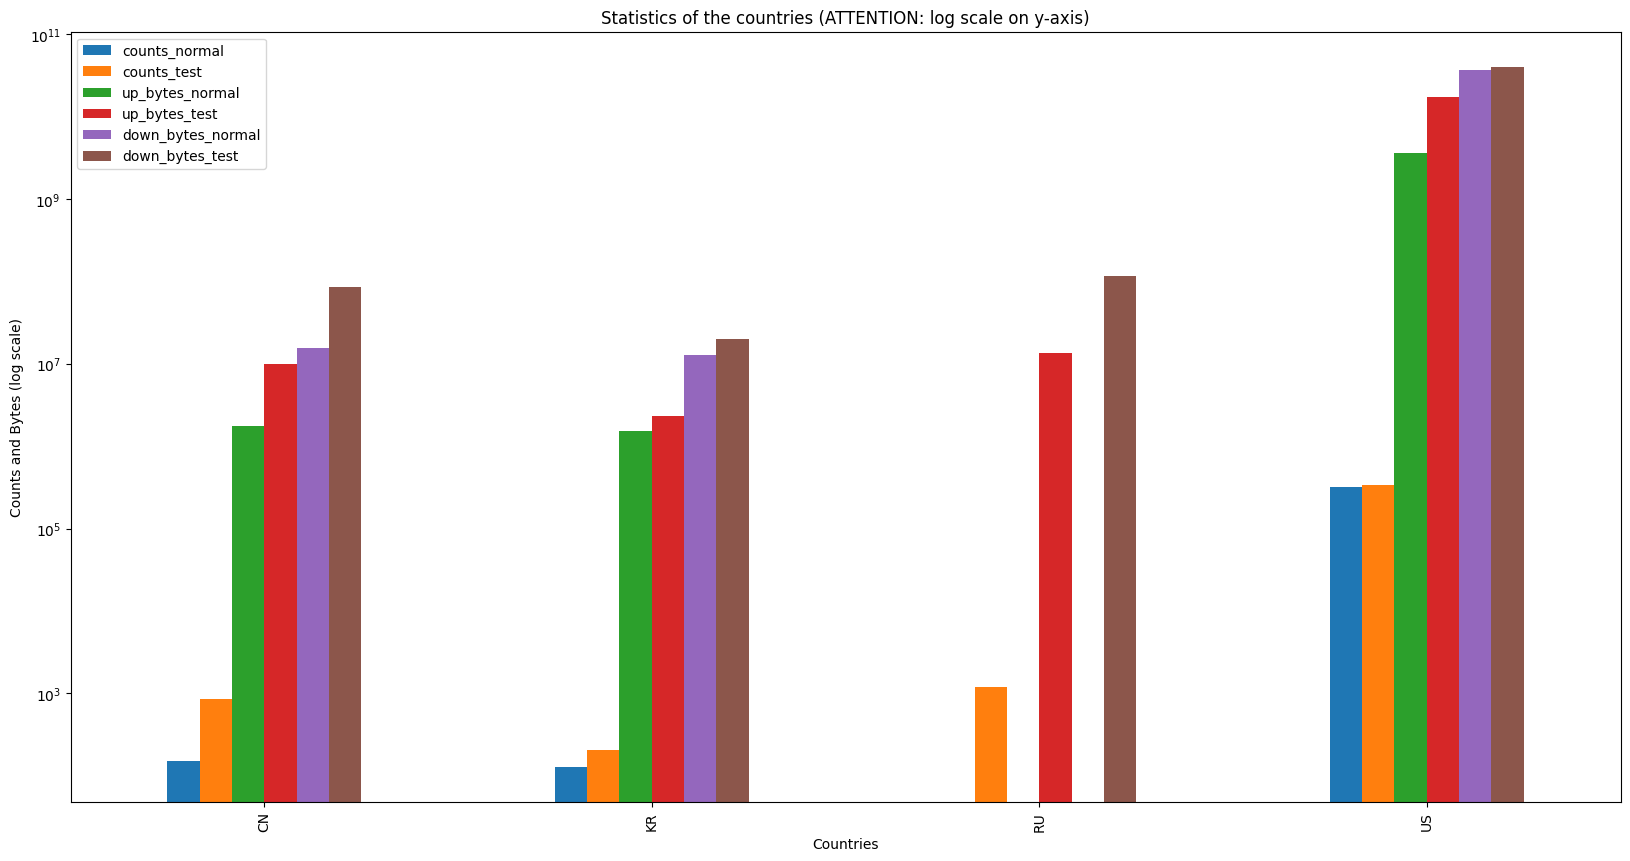

In [80]:
# Number of flows to each country
country_info = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')
# Number of uploaded and downloaded bytes
country_info['up_bytes'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']
country_info['down_bytes'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']

# Plot the top 5 countries with more flows (only, without the bytes)
country_info = country_info.sort_values(by='counts', ascending=False)
country_info = country_info.head(5).set_index('dst_cc')
country_info['counts'].plot.bar(figsize=(20,10), title="Top 5 countries with more flows", xlabel="Country", ylabel="Flows")
plt.savefig('./../plots/top_5_countries_with_more_flows.png')
plt.show()

country_info = country_info.sort_values(by='up_bytes', ascending=False).head(5)
country_info['up_bytes'].plot.bar(figsize=(20,10), title="Top 5 countries with more uploaded bytes", xlabel="Country", ylabel="Flows")
plt.savefig('./../plots/top_5_countries_with_more_flows.png')
plt.show()

country_info = country_info.sort_values(by='down_bytes', ascending=False).head(5)
country_info['down_bytes'].plot.bar(figsize=(20,10), title="Top 5 countries with more downloaded bytes", xlabel="Country", ylabel="Flows")
plt.savefig('./../plots/top_5_countries_with_more_flows.png')
plt.show()


# # Plot the top 5 countries with more flows
# country_info = country_info.sort_values(by='counts', ascending=False)
# country_info = country_info.head(5).set_index('dst_cc')
# country_info.plot.bar(figsize=(20,10), title="Top 5 countries with more flows", xlabel="Country", ylabel="Flows")
# plt.savefig('./../plots/top_5_countries_with_more_flows.png')
# plt.show()

# # Plot the top 5 countries with more uploaded bytes
# country_info = country_info.sort_values(by='up_bytes', ascending=False)
# country_info = country_info.head(5).set_index('dst_cc')
# country_info.plot.bar(figsize=(20,10), title="Top 5 countries with more uploaded bytes", xlabel="Country", ylabel="Bytes")
# plt.savefig('./../plots/top_5_countries_with_more_uploaded_bytes.png')
# plt.show()

# # Plot the top 5 countries with more downloaded bytes
# country_info = country_info.sort_values(by='down_bytes', ascending=False)
# country_info = country_info.head(5).set_index('dst_cc')
# country_info.plot.bar(figsize=(20,10), title="Top 5 countries with more downloaded bytes", xlabel="Country", ylabel="Bytes")
# plt.savefig('./../plots/top_5_countries_with_more_downloaded_bytes.png')
# plt.show()



# Make the mean, standard deviation, min and max of the up_bytes and down_bytes
country_info['up_bytes_mean'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].mean().reset_index(name='up_bytes_mean')['up_bytes_mean']
# country_info['up_bytes_std'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].std().reset_index(name='up_bytes_std')['up_bytes_std']
# country_info['up_bytes_min'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].min().reset_index(name='up_bytes_min')['up_bytes_min']
# country_info['up_bytes_max'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].max().reset_index(name='up_bytes_max')['up_bytes_max']

# Same for down_bytes
country_info['down_bytes_mean'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].mean().reset_index(name='down_bytes_mean')['down_bytes_mean']
# country_info['down_bytes_std'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].std().reset_index(name='down_bytes_std')['down_bytes_std']
# country_info['down_bytes_min'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].min().reset_index(name='down_bytes_min')['down_bytes_min']
# country_info['down_bytes_max'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].max().reset_index(name='down_bytes_max')['down_bytes_max']


# The same for test
country_info_test = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')
country_info_test['up_bytes'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']
country_info_test['down_bytes'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']

country_info_test['up_bytes_mean'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].mean().reset_index(name='up_bytes_mean')['up_bytes_mean']
# country_info_test['up_bytes_std'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].std().reset_index(name='up_bytes_std')['up_bytes_std']
# country_info_test['up_bytes_min'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].min().reset_index(name='up_bytes_min')['up_bytes_min']
# country_info_test['up_bytes_max'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].max().reset_index(name='up_bytes_max')['up_bytes_max']

country_info_test['down_bytes_mean'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].mean().reset_index(name='down_bytes_mean')['down_bytes_mean']
# country_info_test['down_bytes_std'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].std().reset_index(name='down_bytes_std')['down_bytes_std']
# country_info_test['down_bytes_min'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].min().reset_index(name='down_bytes_min')['down_bytes_min']
# country_info_test['down_bytes_max'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].max().reset_index(name='down_bytes_max')['down_bytes_max']

# Merge data information with test
country_diff = pd.merge(country_info, country_info_test, on='dst_cc', how='right')
country_diff = country_diff.fillna(0)

# Removing the ones that have less than 50 counts_y (test), 
# or have a 50% increase between counts_x (normal) and counts_y (test)
# or have a 20% increase between up_bytes_x (normal) and up_bytes_y (test)
# or have a 20% increase between down_bytes_x (normal) and down_bytes_y (test) 
country_diff = country_diff[((country_diff['counts_y'] > 200) &
                            ((country_diff['counts_y'] > (country_diff['counts_x']*2)) |
                            (country_diff['up_bytes_y'] > (country_diff['up_bytes_x']*1.5)) |
                            (country_diff['down_bytes_y'] > (country_diff['down_bytes_x']*1.5))))]
                        
print("Countries with increase of communication to the exterior: \n" + str(country_diff))

# Plot the statistics of the countries
country_diff_plot = country_diff[['dst_cc', 'counts_x', 'counts_y', 'up_bytes_x', 'up_bytes_y', 'down_bytes_x', 'down_bytes_y']].set_index('dst_cc')
country_diff_plot = country_diff_plot.rename(columns={'counts_x': 'counts_normal', 'counts_y': 'counts_test', 'up_bytes_x': 'up_bytes_normal', 'up_bytes_y': 'up_bytes_test', 'down_bytes_x': 'down_bytes_normal', 'down_bytes_y': 'down_bytes_test'})
ax = country_diff_plot.plot.bar(figsize=(20,10), title="Statistics of the countries (ATTENTION: log scale on y-axis)", xlabel="Countries", ylabel="Counts and Bytes (log scale)", logy=True)
plt.savefig('./../plots/statistics_of_the_countries_log_scale.png')
plt.show()


### Country statistics 

In [15]:
# Mean, Standard Deviation and Variance of the flows to each country
country_info = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')
country_info['up_bytes_mean'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].mean().reset_index(name='up_bytes_mean')['up_bytes_mean']
country_info['up_bytes_std'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].std().reset_index(name='up_bytes_std')['up_bytes_std']

# Mean, Standard Deviation and Variance of the flows to each country - test
country_info_test = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')
country_info_test['up_bytes_mean_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].mean().reset_index(name='up_bytes_mean')['up_bytes_mean']
country_info_test['up_bytes_std_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].std().reset_index(name='up_bytes_std')['up_bytes_std']

# Mean, Standard Deviation and Variance of uplodaded bytes per flow to each country
country_info['up_bytes_mean_p_flow'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].mean().reset_index(name='up_bytes_mean')['up_bytes_mean']
country_info['up_bytes_std_p_flow'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].std().reset_index(name='up_bytes_std')['up_bytes_std']
country_info['up_bytes_var_p_flow'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].var().reset_index(name='up_bytes_var')['up_bytes_var']

# Mean, Standard Deviation and Variance of uplodaded bytes per flow to each country - test
country_info_test['up_bytes_mean_p_flow_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].mean().reset_index(name='up_bytes_mean')['up_bytes_mean']
country_info_test['up_bytes_std_p_flow_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].std().reset_index(name='up_bytes_std')['up_bytes_std']
country_info_test['up_bytes_var_p_flow_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['up_bytes'].var().reset_index(name='up_bytes_var')['up_bytes_var']

# Mean, Standard Deviation and Variance of downlodaded bytes per flow to each country
country_info['down_bytes_mean_p_flow'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].mean().reset_index(name='down_bytes_mean')['down_bytes_mean']
country_info['down_bytes_std_p_flow'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].std().reset_index(name='down_bytes_std')['down_bytes_std']
country_info['down_bytes_var_p_flow'] = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].var().reset_index(name='down_bytes_var')['down_bytes_var']

# Mean, Standard Deviation and Variance of downlodaded bytes per flow to each country - test
country_info_test['down_bytes_mean_p_flow_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].mean().reset_index(name='down_bytes_mean')['down_bytes_mean']
country_info_test['down_bytes_std_p_flow_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].std().reset_index(name='down_bytes_std')['down_bytes_std']
country_info_test['down_bytes_var_p_flow_test'] = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc'])['down_bytes'].var().reset_index(name='down_bytes_var')['down_bytes_var']



# Rules and Alarms

### Rule 1 --> Flows increase in 200% 

In [90]:
# Flows and Stats general
normal_stat = data.groupby(['src_ip']).size().reset_index(name='flows')
normal_stat['flows_to_internet'] = data.loc[(data['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)==False)].groupby(['src_ip']).size().reset_index(name='flows_to_internet')['flows_to_internet']
normal_stat['flows_to_private_ips'] = data.loc[(data['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))].groupby(['src_ip']).size().reset_index(name='flows_to_private_ips')['flows_to_private_ips']
normal_stat['flows_to_servers'] = data.loc[(data['dst_ip'].isin(server_ips['index']))].groupby(['src_ip']).size().reset_index(name='flows_to_servers')['flows_to_servers']
normal_stat['total_up_bytes'] = data.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']
normal_stat['up_bytes_per_flow'] = data.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']/normal_stat['flows']
normal_stat['total_down_bytes'] = data.groupby(['src_ip'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']
normal_stat['down_bytes_per_flow'] = data.groupby(['src_ip'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']/normal_stat['flows']
normal_stat['% udp_flows'] = data.loc[(data['proto']=='udp')].groupby(['src_ip']).size().reset_index(name='udp_flows')['udp_flows']/normal_stat['flows']
normal_stat['% tcp_flows'] = data.loc[(data['proto']=='tcp')].groupby(['src_ip']).size().reset_index(name='tcp_flows')['tcp_flows']/normal_stat['flows']
normal_stat['up_bytes_per_tcp_flow'] = data.loc[(data['proto']=='tcp')].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']/normal_stat['% tcp_flows']
normal_stat['up_bytes_per_udp_flow'] = data.loc[(data['proto']=='udp')].groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes']/normal_stat['% udp_flows']
normal_stat['down_bytes_per_tcp_flow'] = data.loc[(data['proto']=='tcp')].groupby(['src_ip'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']/normal_stat['% tcp_flows']
normal_stat['down_bytes_per_udp_flow'] = data.loc[(data['proto']=='udp')].groupby(['src_ip'])['down_bytes'].sum().reset_index(name='down_bytes')['down_bytes']/normal_stat['% udp_flows']

mean_flows = normal_stat['flows'].mean()
mean_flows_to_internet = normal_stat['flows_to_internet'].mean()
mean_flows_to_private_ips = normal_stat['flows_to_private_ips'].mean()
mean_flows_to_servers = normal_stat['flows_to_servers'].mean()
mean_total_up_bytes = normal_stat['total_up_bytes'].mean()
mean_up_bytes_per_flow = normal_stat['up_bytes_per_flow'].mean()
mean_total_down_bytes = normal_stat['total_down_bytes'].mean()
mean_down_bytes_per_flow = normal_stat['down_bytes_per_flow'].mean()
mean_perc_udp_flows = normal_stat['% udp_flows'].mean()
mean_perc_tcp_flows = normal_stat['% tcp_flows'].mean()
mean_up_bytes_per_tcp_flow = normal_stat['up_bytes_per_tcp_flow'].mean()
mean_up_bytes_per_udp_flow = normal_stat['up_bytes_per_udp_flow'].mean()
mean_down_bytes_per_tcp_flow = normal_stat['down_bytes_per_tcp_flow'].mean()
mean_down_bytes_per_udp_flow = normal_stat['down_bytes_per_udp_flow'].mean()


# Average server IPs access (server IPs: 234, 239, 224, 228)
avg_server_access = data.loc[(data['dst_ip'].isin(server_ips['index']))].groupby(['src_ip']).size().reset_index(name='counts')
avg_server_access = avg_server_access['counts'].mean()
print("Average server IPs access: \n" + str(int(avg_server_access)))

# check the test flows that access the server IPs (server IPs: 234, 239, 224, 228) with more than 50 flows and 3 times the average
test_server_access = test.loc[(test['dst_ip'].isin(server_ips['index']))].groupby(['src_ip']).size().reset_index(name='counts')
test_server_access = test_server_access[test_server_access['counts'] > (avg_server_access*3)]
print("The IPs that activate an alarm: \n" + test_server_access.to_string(index=False))
# check the test flows that access the server IPs (server IPs: 234, 239, 224, 228) with more than 50 flows and 3 times the average
test_server_access = test.loc[(test['dst_ip'].isin(server_ips['index']))].groupby(['src_ip']).size().reset_index(name='counts')
test_server_access = test_server_access[test_server_access['counts'] > (avg_server_access*5)]

print("The IPs to be blocked: \n" + test_server_access.to_string(index=False))



Average server IPs access: 
1322
The IPs that activate an alarm: 
         src_ip  counts
192.168.101.139    4108
 192.168.101.41   46161
 192.168.101.42   77974
 192.168.101.60   47980
The IPs to be blocked: 
        src_ip  counts
192.168.101.41   46161
192.168.101.42   77974
192.168.101.60   47980


### Rule 2 --> Internal Communications

In [91]:
# Check for internal comms in normal (private IP to private IP)
normal_internal = data.loc[(data['src_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (data['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]
normal_internal = normal_internal.groupby(['src_ip', 'dst_ip']).size().reset_index(name='counts')
#print("Internal communications in normal: \n" + str(normal_internal))

# Average count of internal comms
avg_internal = normal_internal['counts'].mean()
print("Average internal communications flows: \n" + str(int(avg_internal)))

# Check for new internal comms in test (private IP to private IP)
test_internal = test.loc[(test['src_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)) & (test['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private))]
test_internal = test_internal.groupby(['src_ip', 'dst_ip']).size().reset_index(name='counts')
#print("Internal communications in test: \n" + str(test_internal))

# Get the difference to check the new internal comms in test
internal_diff = pd.merge(normal_internal, test_internal, on=['src_ip', 'dst_ip'], how='right')
internal_diff = internal_diff.fillna(0)
internal_diff = internal_diff[(internal_diff['counts_x'] == 0) & (internal_diff['counts_y'] > 0)]
internal_diff = internal_diff[['src_ip', 'dst_ip', 'counts_y']]
internal_diff = internal_diff.rename(columns={'counts_y': 'counts'})
# print("New internal communications flows: \n" + str(internal_diff))

# Check in the old internal comms if there are any that have more than 3 times the average
internal_diff = pd.merge(normal_internal, test_internal, on=['src_ip', 'dst_ip'], how='right')
internal_diff = internal_diff.fillna(0)
internal_diff = internal_diff[(internal_diff['counts_x'] > (avg_internal*3)) & (internal_diff['counts_y'] > 0)]
internal_diff = internal_diff[['src_ip', 'dst_ip', 'counts_y']]
internal_diff = internal_diff.rename(columns={'counts_y': 'counts'})
print("Alarm on this Internal communications flows: \n" + internal_diff.to_string(index=False))



Average internal communications flows: 
331
Alarm on this Internal communications flows: 
         src_ip          dst_ip  counts
192.168.101.152 192.168.101.239     529
192.168.101.154 192.168.101.234     415
192.168.101.154 192.168.101.239     457
192.168.101.204 192.168.101.234    1025
192.168.101.204 192.168.101.239     977


### Rule 3 --> Naughty Countries

In [103]:
# Check the average of flows per country
avg_flows_country = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')
avg_flows_country = avg_flows_country['counts'].mean()
print("Average flows per country: \n" + str(int(avg_flows_country)))

# Check if the test has more than 18 times the average OR is INF of flows per country
test_flows_country = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')
test_flows_country = test_flows_country[(test_flows_country['counts'] > (avg_flows_country*18)) | (test_flows_country['counts'] == float('inf'))]
print("The IPs that activate an alarm: \n" + test_flows_country.to_string(index=False))

# Check for countries that exist in test but not in normal
test_flows_country = test.loc[~(test['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')
test_flows_country = test_flows_country[~(test_flows_country['dst_cc'].isin(data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['dst_cc']).size().reset_index(name='counts')['dst_cc']))]

# Check which of those countries have more than 500 flows
test_flows_country = test_flows_country[test_flows_country['counts'] > 500]
print("The IPs to be blocked: \n" + test_flows_country.to_string(index=False))

Average flows per country: 
17400
The IPs that activate an alarm: 
dst_cc  counts
    US  343024
The IPs to be blocked: 
dst_cc  counts
    RU    1209


### Rule 4 --> Upload Volumes

In [109]:
# Average upload bytes in normal
avg_up_bytes = data.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')['up_bytes'].mean()
print("Average upload bytes: \n" + str((avg_up_bytes)))

# Check if there are flows in test that pass 3 times the average upload bytes 
test_up_bytes = test.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
test_up_bytes = test_up_bytes[test_up_bytes['up_bytes'] > (avg_up_bytes*3)]
print("The IPs that activate an alarm: \n" + test_up_bytes.to_string(index=False))

# Check if there are flows in test that pass 5 times the average upload bytes 
test_up_bytes = test.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes')
test_up_bytes = test_up_bytes[test_up_bytes['up_bytes'] > (avg_up_bytes*5)]
print("The IPs to be blocked: \n" + test_up_bytes.to_string(index=False))


Average upload bytes: 
45549345.37244898
The IPs that activate an alarm: 
         src_ip   up_bytes
192.168.101.106  182098144
192.168.101.151 6833154822
192.168.101.209 6573399109
The IPs to be blocked: 
         src_ip   up_bytes
192.168.101.151 6833154822
192.168.101.209 6573399109


### Rule 5 --> New protocols or More frequent protocols

In [120]:
# Check the used protocols
normal_protocols = data.groupby(['proto']).size().reset_index(name='counts')
normal_protocols['%'] = normal_protocols['counts']/normal_protocols['counts'].sum()
print("Protocols in normal: \n" + normal_protocols.to_string(index=False))

# Check if there's a new protocol in test
test_protocols = test.groupby(['proto']).size().reset_index(name='counts')
test_protocols['%'] = test_protocols['counts']/test_protocols['counts'].sum()
test_protocols = pd.merge(normal_protocols, test_protocols, on='proto', how='right')
test_protocols = test_protocols.fillna(0)
test_protocols = test_protocols[(test_protocols['counts_x'] == 0) & (test_protocols['counts_y'] > 0)]
test_protocols = test_protocols[['proto', 'counts_y', '%_y']]
test_protocols = test_protocols.rename(columns={'counts_y': 'counts', '%_y': '%'})
print("[ALARM] New protocols in test: \n" + test_protocols.to_string(index=False))


Protocols in normal: 
proto  counts        %
  tcp  778928 0.879585
  udp  106635 0.120415
[ALARM] New protocols in test: 
Empty DataFrame
Columns: [proto, counts, %]
Index: []
[ALARM] Significant changes in protocol distribution: 
proto  counts_test   %_test  counts_normal  %_normal
  udp       286727 0.253211         106635  0.120415


### Rule 6 --> New ports (check port scanning)

In [124]:
# Check the used ports
normal_ports = data.groupby(['port']).size().reset_index(name='counts')
normal_ports['%'] = normal_ports['counts']/normal_ports['counts'].sum()
print("Ports in normal: \n" + normal_ports.to_string(index=False))

# Check if there's a new port in test
test_ports = test.groupby(['port']).size().reset_index(name='counts')
test_ports['%'] = test_ports['counts']/test_ports['counts'].sum()
test_ports = pd.merge(normal_ports, test_ports, on='port', how='right')
test_ports = test_ports.fillna(0)
test_ports = test_ports[(test_ports['counts_x'] == 0) & (test_ports['counts_y'] > 0)]
test_ports = test_ports[['port', 'counts_y', '%_y']]
test_ports = test_ports.rename(columns={'counts_y': 'counts', '%_y': '%'})
print("[ALARM] New ports in test: \n" + test_ports.to_string(index=False))


Ports in normal: 
 port  counts        %
   53  104516 0.118022
  443  781047 0.881978
[ALARM] New ports in test: 
Empty DataFrame
Columns: [port, counts, %]
Index: []


### Some extra things, I don't know

In [ ]:

#Average number of flows per IP - normal
normal_flows = data.groupby(['src_ip']).size().reset_index(name='counts_normal')
# Average number of flows per IP - test
test_flows = test.groupby(['src_ip']).size().reset_index(name='counts_test')
print("Average number of flows per IP - normal: \n" + str(normal_flows['counts_normal'].mean()))
print("Average number of flows per IP - test: \n" + str(test_flows['counts_test'].mean()))
# Average growth of flows per IP
print("Average growth of flows per IP: \n" + str(((test_flows['counts_test'].mean() - normal_flows['counts_normal'].mean()) / normal_flows['counts_normal'].mean()) * 100))

# Standard deviation between the number of flows per IP - normal vs test
print("Standard deviation between the number of flows per IP - normal vs test: \n" + str(np.std(normal_flows['counts_normal'] - test_flows['counts_test'])))

# Check the normal TCP flows per IP
normal_tcp_flows = data[data['proto'] == 'tcp'].groupby(['src_ip']).size().reset_index(name='counts_normal')
# Check the normal TCP flows per IP - test
test_tcp_flows = test[test['proto'] == 'tcp'].groupby(['src_ip']).size().reset_index(name='counts_test')
# If the number of TCP flows is more than 600% higher than the normal, then it is suspicious
tcp_flows_diff = pd.merge(normal_tcp_flows, test_tcp_flows, on='src_ip', how='inner')
tcp_flows_diff = tcp_flows_diff[(tcp_flows_diff['counts_test'] > (tcp_flows_diff['counts_normal']*6))]
print("Suspicious IPs with increase of TCP flows: \n" + str(tcp_flows_diff))

# Average number of TCP flows per IP - normal
normal_tcp_flows = data[data['proto'] == 'tcp'].groupby(['src_ip']).size().reset_index(name='counts_normal')
# Average number of TCP flows per IP - test
test_tcp_flows = test[test['proto'] == 'tcp'].groupby(['src_ip']).size().reset_index(name='counts_test')
print("Average number of TCP flows per IP - normal: \n" + str(normal_tcp_flows['counts_normal'].mean()))
print("Average number of TCP flows per IP - test: \n" + str(test_tcp_flows['counts_test'].mean()))
# Average growth of TCP flows per IP
print("Average growth of TCP flows per IP: \n" + str(((test_tcp_flows['counts_test'].mean() - normal_tcp_flows['counts_normal'].mean()) / normal_tcp_flows['counts_normal'].mean()) * 100))

# Standard deviation between the number of TCP flows per IP - normal vs test
print("Standard deviation between the number of TCP flows per IP - normal vs test: \n" + str(np.std(normal_tcp_flows['counts_normal'] - test_tcp_flows['counts_test'])))

# Check the normal number of UDP flows per IP
normal_udp_flows = data[data['proto'] == 'udp'].groupby(['src_ip']).size().reset_index(name='counts_normal')
# Check the normal number of UDP flows per IP - test
test_udp_flows = test[test['proto'] == 'udp'].groupby(['src_ip']).size().reset_index(name='counts_test')
# If the number of UDP flows is more than 600% higher than the normal, then it is suspicious
udp_flows_diff = pd.merge(normal_udp_flows, test_udp_flows, on='src_ip', how='inner')
udp_flows_diff = udp_flows_diff[(udp_flows_diff['counts_test'] > (udp_flows_diff['counts_normal']*6))]
print("Suspicious IPs with increase of UDP flows: \n" + str(udp_flows_diff))

# Average number of UDP flows per IP - normal
normal_udp_flows = data[data['proto'] == 'udp'].groupby(['src_ip']).size().reset_index(name='counts_normal')
# Average number of UDP flows per IP - test
test_udp_flows = test[test['proto'] == 'udp'].groupby(['src_ip']).size().reset_index(name='counts_test')
print("Average number of UDP flows per IP - normal: \n" + str(normal_udp_flows['counts_normal'].mean()))
print("Average number of UDP flows per IP - test: \n" + str(test_udp_flows['counts_test'].mean()))
# Average growth of UDP flows per IP
print("Average growth of UDP flows per IP: \n" + str(((test_udp_flows['counts_test'].mean() - normal_udp_flows['counts_normal'].mean()) / normal_udp_flows['counts_normal'].mean()) * 100))

# Standard deviation between the number of UDP flows per IP - normal vs test
print("Standard deviation between the number of UDP flows per IP - normal vs test: \n" + str(np.std(normal_udp_flows['counts_normal'] - test_udp_flows['counts_test'])))

# From those UDP flows, check the ones that go to port 53
udp_53_flows = data[(data['proto'] == 'udp') & (data['dst_port'] == 53)].groupby(['src_ip']).size().reset_index(name='counts_normal')
# From those UDP flows, check the ones that go to port 53 - test
udp_53_flows_test = test[(test['proto'] == 'udp') & (test['dst_port'] == 53)].groupby(['src_ip']).size().reset_index(name='counts_test')
# If the number of UDP flows to port 53 is more than 600% higher than the normal, then it is suspicious
udp_53_flows_diff = pd.merge(udp_53_flows, udp_53_flows_test, on='src_ip', how='inner')
udp_53_flows_diff = udp_53_flows_diff[(udp_53_flows_diff['counts_test'] > (udp_53_flows_diff['counts_normal']*6))]
print("Suspicious IPs with increase of UDP flows to port 53: \n" + str(udp_53_flows_diff))

# Average number of UDP flows to port 53 per IP - normal
udp_53_flows = data[(data['proto'] == 'udp') & (data['dst_port'] == 53)].groupby(['src_ip']).size().reset_index(name='counts_normal')
# Average number of UDP flows to port 53 per IP - test
udp_53_flows_test = test[(test['proto'] == 'udp') & (test['dst_port'] == 53)].groupby(['src_ip']).size().reset_index(name='counts_test')
print("Average number of UDP flows to port 53 per IP - normal: \n" + str(udp_53_flows['counts_normal'].mean()))
print("Average number of UDP flows to port 53 per IP - test: \n" + str(udp_53_flows_test['counts_test'].mean()))
# Average growth of UDP flows to port 53 per IP
print("Average growth of UDP flows to port 53 per IP: \n" + str(((udp_53_flows_test['counts_test'].mean() - udp_53_flows['counts_normal'].mean()) / udp_53_flows['counts_normal'].mean()) * 100))

# Standard deviation between the number of UDP flows to port 53 per IP - normal vs test
print("Standard deviation between the number of UDP flows to port 53 per IP - normal vs test: \n" + str(np.std(udp_53_flows['counts_normal'] - udp_53_flows_test['counts_test'])))

# From those UDP flows, check the ones that go to port 443
udp_443_flows = data[(data['proto'] == 'udp') & (data['dst_port'] == 443)].groupby(['src_ip']).size().reset_index(name='counts_normal')
# From those UDP flows, check the ones that go to port 443 - test
udp_443_flows_test = test[(test['proto'] == 'udp') & (test['dst_port'] == 443)].groupby(['src_ip']).size().reset_index(name='counts_test')
# If the number of UDP flows to port 443 is more than 600% higher than the normal, then it is suspicious
udp_443_flows_diff = pd.merge(udp_443_flows, udp_443_flows_test, on='src_ip', how='inner')
udp_443_flows_diff = udp_443_flows_diff[(udp_443_flows_diff['counts_test'] > (udp_443_flows_diff['counts_normal']*6))]
print("Suspicious IPs with increase of UDP flows to port 443: \n" + str(udp_443_flows_diff))

# Average number of UDP flows to port 443 per IP - normal
udp_443_flows = data[(data['proto'] == 'udp') & (data['dst_port'] == 443)].groupby(['src_ip']).size().reset_index(name='counts_normal')
# Average number of UDP flows to port 443 per IP - test
udp_443_flows_test = test[(test['proto'] == 'udp') & (test['dst_port'] == 443)].groupby(['src_ip']).size().reset_index(name='counts_test')
print("Average number of UDP flows to port 443 per IP - normal: \n" + str(udp_443_flows['counts_normal'].mean()))
print("Average number of UDP flows to port 443 per IP - test: \n" + str(udp_443_flows_test['counts_test'].mean()))
# Average growth of UDP flows to port 443 per IP
print("Average growth of UDP flows to port 443 per IP: \n" + str(((udp_443_flows_test['counts_test'].mean() - udp_443_flows['counts_normal'].mean()) / udp_443_flows['counts_normal'].mean()) * 100))

# Check the normal upload bytes per flow per IP
normal_upload = data.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes_normal')
normal_flows = data.groupby(['src_ip']).size().reset_index(name='counts_normal')
normal_upload = pd.merge(normal_upload, normal_flows, on='src_ip', how='inner')
normal_upload['avg_up_bytes'] = normal_upload['up_bytes_normal'] / normal_upload['counts_normal']
# Check the normal upload bytes per flow per IP - test
test_upload = test.groupby(['src_ip'])['up_bytes'].sum().reset_index(name='up_bytes_normal')
test_flows = test.groupby(['src_ip']).size().reset_index(name='counts_normal')
test_upload = pd.merge(test_upload, test_flows, on='src_ip', how='inner')
test_upload['avg_up_bytes'] = test_upload['up_bytes_normal'] / test_upload['counts_normal']
# If the number of uploaded bytes is 250% higher than the normal, then it is suspicious
upload_diff = pd.merge(normal_upload, test_upload, on='src_ip', how='inner')
upload_diff = upload_diff[(upload_diff['avg_up_bytes_y'] > (upload_diff['avg_up_bytes_x']*2.5))]
print("Suspicious IPs with increase of uploaded bytes: \n" + str(upload_diff))

# Average growth of uploaded bytes per flow per IP
print("Average growth of uploaded bytes per flow per IP: \n" + str(((test_upload['avg_up_bytes'].mean() - normal_upload['avg_up_bytes'].mean()) / normal_upload['avg_up_bytes'].mean()) * 100))

# New IPs that are communicating internally are botnet suspects
internal_suspect_ips = np.setdiff1d(internal_flows_test['src_ip'].unique(), internal_flows['src_ip'].unique())
print("New IPs that are communicating internally: \n" + str(internal_suspect_ips))

# Check this IPs upload bytes, download bytes and flows 
internal_suspect_ips_bytes = internal_flows_test[internal_flows_test['src_ip'].isin(internal_suspect_ips)]
internal_suspect_ips_down_bytes = internal_suspect_ips_bytes.groupby(['src_ip'])['down_bytes'].sum().apply(lambda x: bytes_to_mb(x))
internal_suspect_ips_up_bytes = internal_suspect_ips_bytes.groupby(['src_ip'])['up_bytes'].sum().apply(lambda x: bytes_to_mb(x))
internal_suspect_ips_flows = internal_suspect_ips_bytes.groupby(['src_ip']).size().reset_index(name='counts')
print("Internal Suspect IPs that are communicating internally how much MBytes: \n" + str(internal_suspect_ips_down_bytes) + "\n" +
        "Internal Suspect IPs that are communicating internally how much MBytes: \n" + str(internal_suspect_ips_up_bytes) + "\n" +
        "Internal Suspect IPs that are communicating internally how much flows: \n" + str(internal_suspect_ips_flows))

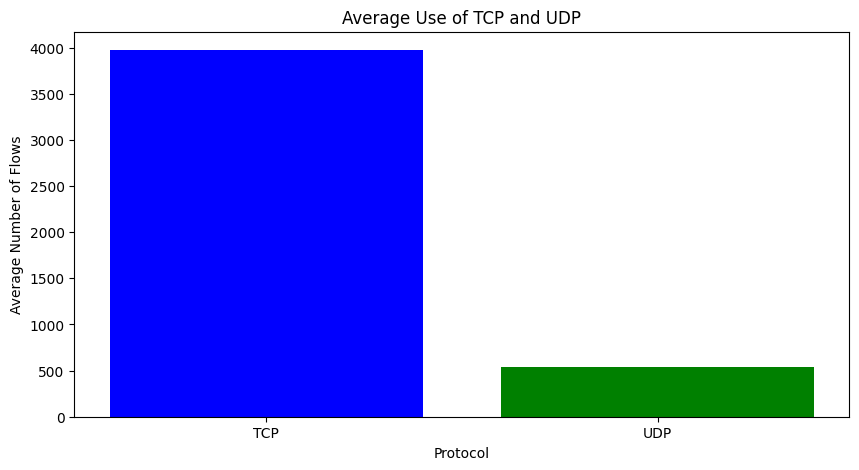

In [ ]:
# Calculate the average number of TCP flows per source IP
avg_tcp = data[data['proto'] == 'tcp'].groupby(['src_ip']).size().mean()

# Calculate the average number of UDP flows per source IP
avg_udp = data[data['proto'] == 'udp'].groupby(['src_ip']).size().mean()

# Data to plot
protocols = ['TCP', 'UDP']
averages = [avg_tcp, avg_udp]

# Create a bar chart
plt.figure(figsize=(10,5))
plt.bar(protocols, averages, color=['blue', 'green'])
plt.xlabel('Protocol')
plt.ylabel('Average Number of Flows')
plt.title('Average Use of TCP and UDP')

# Save the figure
plt.savefig('./../plots/average_use_of_tcp_and_udp.png')
plt.show()




# # Calculate the size for each group
# sizes = data.groupby(['src_ip']).size()
# sizes_out = data.loc[~(data['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip']).size()
# sizes_in = data.loc[(data['dst_ip']).str.startswith('192.168.101.')].groupby(['src_ip']).size()

# # Calculate the mean of the sizes
# mean_flows = sizes.mean()
# mean_flows_out = sizes_out.mean()
# mean_flows_in = sizes_in.mean()

# # Plot the means
# means = pd.DataFrame({'mean_out': [mean_flows_out], 'mean_in': [mean_flows_in]})
# means.plot.bar(figsize=(20,10), title="Mean number of flows", xlabel="Categories", ylabel="Mean number of flows")
# plt.xticks(ticks=[0], labels=["Means"], rotation=0)
# plt.savefig('./../plots/mean_number_of_flows.png')
# plt.show()

# # Plot the top 5 outside IPs with more flows
# # Get the top 5 outside IPs with more flows
# top_5_out = external_flows.groupby(['src_ip']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False).head(10)
# # Plot the top 5 outside IPs with more flows
# top_5_out.plot.bar(x='src_ip', y='counts', figsize=(20,10), title="Top 10 outside IPs with more flows", xlabel="IPs", ylabel="Number of flows")
# plt.savefig('./../plots/top_10_outside_ips_with_more_flows.png')
# plt.show()

# # Plot the top 10 countries with more flows adding a note about the NaN values
# # Get the top 10 countries with more flows
# top_10_countries = data.groupby(['dst_cc']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False).head(10)
# # Plot the top 10 countries with more flows
# top_10_countries.plot.bar(x='dst_cc', y='counts', figsize=(20,10), title="Top 10 countries with more flows", xlabel="Countries", ylabel="Number of flows")
# plt.savefig('./../plots/top_10_countries_with_more_flows.png')
# plt.show()


# # Plot the top 10 organizations with more flows
# # Get the top 10 organizations with more flows
# top_10_orgs = data.groupby(['dst_org']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False).head(10)
# # Plot the top 10 organizations with more flows
# top_10_orgs.plot.bar(x='dst_org', y='counts', figsize=(20,10), title="Top 10 organizations with more flows", xlabel="Organizations", ylabel="Number of flows")
# plt.savefig('./../plots/top_10_organizations_with_more_flows.png')
# plt.show()


